In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from glob import glob
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from specutils.manipulation import LinearInterpolatedResampler

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [2]:
spectrum_files = glob(os.path.join('HST','anonymous37222', '*.fits'))

In [193]:
# Load in RU Lupi data
#spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))

In [194]:
#spectrum_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))

In [ ]:
INST_head = [fits.getheader(file, ext=0) for file in spectrum_files]
SCI_head = [fits.getheader(file, ext=1) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [50]:
#date = [header['DATE-OBS'] for header in spectrum_header]
#observing_run = [header['ROOTNAME'] for header in spectrum_header]
instrument = [header['INSTRUME'] for header in spectrum_header_0]
#instrument_filter = [header['OPT_ELEM'] for header in spectrum_header_0]

In [ ]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv

lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)
#lab_emission_lines = lines['lab_lambda']
#transition_grouped_lines = lines.groupby("[nu', J']")

In [ ]:
spectrum_x1d[0]

In [ ]:
file_idx = 5
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.ravel(spectrum_x1d[file_idx]['WAVELENGTH'])
#wavesort_idx = np.argsort(x1d_wavelength)
#x1d_wavelength = x1d_wavelength[wavesort_idx]

x1d_flux = np.ravel(spectrum_x1d[file_idx]['FLUX'])
x1d_fluxerr = np.ravel(spectrum_x1d[file_idx]['ERROR'])

#x1d_flux = x1d_flux[wavesort_idx]
#x1d_fluxerr = x1d_fluxerr[wavesort_idx]

In [ ]:
# spectrum = Spectrum1D(flux = x1d_flux, spectral_axis=x1d_wavelength)
# x1d_lines = find_lines_derivative(spectrum) #noise_factor is the threshold (x*flux error)
# x1d_emissions = x1d_lines[x1d_lines['line_type']=='emission']

In [ ]:
peaks , _ = find_peaks(np.array(x1d_flux), height=max(x1d_fluxerr.value)*2, distance=100)

In [ ]:
plt.plot(x1d_wavelength,x1d_flux)
plt.scatter(x1d_wavelength[peaks], x1d_flux[peaks], c='red', marker='x')
plt.xlim(left=1390)
plt.show()

In [ ]:
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

In [ ]:
plt.scatter(np.array(x1d_wavelength[peaks])[emission_table_idx], np.array(x1d_flux[peaks])[emission_table_idx], c='r', marker='x')
plt.plot(x1d_wavelength,x1d_flux)
#plt.xlim(left=1380)
plt.show()

In [ ]:
line_width = 150
x1d_h2_emissions_idx = np.array(peaks)[emission_table_idx]
x1d_h2_emissions_flux = [x1d_flux[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_fluxerr = [x1d_fluxerr[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_wavelength = [x1d_wavelength[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]

In [ ]:
plt.scatter(np.array(x1d_wavelength)[x1d_h2_emissions_idx], np.array(x1d_flux)[x1d_h2_emissions_idx], c='r', marker='x')
plt.plot(x1d_wavelength, x1d_flux)
plt.xlim(left=1380)
plt.show()

In [ ]:
colnames = ['Line ID', "[nu', J']", "lab_lambda", "spec_flux", "spec_fluxerr", "spec_wavelength"]

line_ID = np.array(lab_line_row)[:, 0]
nu_J = np.array(lab_line_row)[:, 1]
lab_lambda = np.array(lab_line_row)[:, 2]

# Ensure all are 1D numpy arrays or lists of same length
line_ID = np.asarray(line_ID)
nu_J = np.asarray(nu_J)
lab_lambda = np.asarray(lab_lambda)
flux = x1d_h2_emissions_flux
fluxerr = x1d_h2_emissions_fluxerr
wavelength = x1d_h2_emissions_wavelength

# Combine row-wise
data = list(zip(line_ID, nu_J, lab_lambda, flux, fluxerr, wavelength))
spectrum_df = pd.DataFrame(data, columns=colnames)

In [ ]:
spectrum_df.index = spectrum_df["[nu', J']"]
spectrum_df

In [ ]:
transition='[0,3]'
plt.plot(np.hstack(spectrum_df['spec_wavelength'][transition]), np.hstack(spectrum_df['spec_flux'][transition]))

# Do this for every file, just keep the line centers though. Making it a function

In [2]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
clrs = sns.color_palette('Set1')
clrs[5] = (255/255, 200/255, 80/255)
colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=False)

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
#plt.rcParams['figure.dpi'] = 300

In [17]:
#Keep units for future math
class spectrum():
    def __init__(self, files, linelist_file):
        """
        Initialize spectrum, unpack spectra into useable arrays
        
        Parameters:
        - files: a list of .fits files from HST, each with a header hdu, and a spectrum BinTable hdu
        """
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**2)))
        self.wavelength_units = u.AA
        self.linelist = None
        self.linelist = pd.read_csv(linelist_file, skiprows=2)
        #construct dataframe with filename, relevant header information, and spectrum information for each file.
        #Then add to a list of dataframes from files
        rows = []
        for file in files:
            #Use np.ravel here because the wavelength in the table  is a list in one table cell (e.g. [[1, 2, 3]])
            INST_head = fits.getheader(file, ext=0)
            SCI_head = fits.getheader(file, ext=1)
            spectrum_x1d = Table.read(file, hdu=1)
            
            self.x1d_wavelength = np.ravel(spectrum_x1d['WAVELENGTH'])/self.wavelength_units
            self.x1d_flux = np.ravel(spectrum_x1d['FLUX'])/self.flux_units
            self.x1d_fluxerr = np.ravel(spectrum_x1d['ERROR'])/self.flux_units
            if "cspec" in file:
                date = SCI_head['DATE-BEG'][:10]
            elif "x1dsum" in file:
                date = SCI_head['DATE-OBS']
            instrument = INST_head['INSTRUME']
            try:
                instrument_filter = INST_head['OPT_ELEM']
            except KeyError:
                instrument_filter = INST_head['GRATING'] #in cspec header
            df_data = {'filename':file, 
                       'obsdate':date,
                       'instrument':instrument, 
                       'filter':instrument_filter, 
                       'wavelength':self.x1d_wavelength*self.wavelength_units, 
                       'flux': self.x1d_flux*self.flux_units, 
                       'fluxerr':self.x1d_fluxerr*self.flux_units}
            rows.append(pd.Series(df_data))
        self.spec_df = pd.DataFrame(rows)
        drop_idx = []
        for i in range(len(self.spec_df)-1):
            if len(self.spec_df.iloc[i]['wavelength'])<1:
                drop_idx.append(i)
        self.spec_df.drop(labels=drop_idx, inplace=True)
        self.spec_df.reset_index(drop=True, inplace=True)
        self.spec_df['obsdate'] = self.spec_df['obsdate'].astype(str)

    def coaddwave(self, df, columns=['obsdate']):
        """
        Co-add spectra using the spectrum1D function.

        Parameters:
        - df: The dataframe to use for co-adding. Must contain 'wavelength', 
              'flux', and 'fluxerr' columns at least. If using velocity_space, must contain 'rest_wavelength' column.
        - columns: the columns of unique combinations to apply coadding to.

        Returns:
        - coadded_spectrum: spectrum dataframe
        """

        res = {}
        combinations = df[columns].drop_duplicates()
        for _, row in combinations.iterrows():
            unique_values = [row[col] for col in columns]

            # Filter the group
            mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
            group = df[mask]

            resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
            wavelengths = group['wavelength'].values
            fluxes = group['flux'].values
            fluxerrs = group['fluxerr'].values
            lablines = [None] * len(wavelengths)
            
            template_axis = wavelengths[0][np.argsort(wavelengths[0])]
            template_flux = fluxes[0][np.argsort(wavelengths[0])]
            template_fluxerr = fluxerrs[0][np.argsort(wavelengths[0])]
            
            coadded = Spectrum1D(
                flux=template_flux,
                spectral_axis=template_axis,
                uncertainty=StdDevUncertainty(template_fluxerr)
            )

            for i in np.arange(0, len(wavelengths)):
                x = wavelengths[i]
                flux = fluxes[i]
                err = fluxerrs[i]
                sort_idx = np.argsort(x)
                spec = Spectrum1D(spectral_axis=x[sort_idx], 
                                    flux=flux[sort_idx], 
                                    uncertainty=StdDevUncertainty(err[sort_idx])
                                )
                
                spec_resampled = resampler(spec, coadded.spectral_axis)
                coadded += spec_resampled
            
            coadd_wave = coadded.wavelength
            coadd_flux = coadded.flux
            coadd_err = coadded.uncertainty.quantity.to(self.flux_units)
            spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err}
            res[tuple(unique_values)] = spec_dict

        stacked_df = pd.DataFrame([
            {**dict(zip(columns, k)), **(v if v is not None else {})}
            for k, v in res.items()
        ])
        return stacked_df
    
    def coaddvel(self, df, columns):
        res = {}
        combinations = df[columns].drop_duplicates()
        for _, row in combinations.iterrows():
            unique_values = [row[col] for col in columns]
            # Filter the group
            mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
            group = df[mask]
            
            coadded_flux = group['flux'].iloc[0].value.copy()
            templatev = self.radial_velocity(group['wavelength'].iloc[0],
                                                    group['labline'].iloc[0]).value
            coadd_error = group['fluxerr'].iloc[0].value.copy()
            for _, row in group.iterrows():
                velocity = self.radial_velocity(row['wavelength'], row['labline']).value
                resampled_flux = np.interp(templatev, velocity, row['flux'])
                resampled_fluxerr = np.interp(templatev, velocity, row['fluxerr'])
                coadded_flux += resampled_flux.value
                coadd_error += resampled_fluxerr.value

            N = len(group)
            coadded_flux = coadded_flux/N
            coadded_error = np.sqrt(coadd_error)/N
            spec_dict = {'wavelength': group['wavelength'].iloc[0], 'flux':coadded_flux*self.flux_units, 'fluxerr': coadded_error*self.flux_units, 'velocity': templatev*(u.km/u.s)}
            res[tuple(unique_values)] = spec_dict

        prog_df = pd.DataFrame([
            {**dict(zip(columns, k)), **(v if v is not None else {})}
            for k, v in res.items()
        ])

        return prog_df

    def H2lines_fromspectrum(self, df):
        """
        Get the H2 line peaks from the spectrum, and add the peaks to the spectrum dataframe

        Parameters:
        - linelist: an array of

        Returns:
        - Line peak indices and the associated transitions added to the original dataframe
        """
        df['H2line_idx'] = None
        df["[nu', J']"] = None
        df["rest_wavelength"] = None
        for i in range(len(df)):
            row = df.iloc[i]
            #peaks , _ = find_peaks(np.array(row['flux'].value), height=np.array(row['fluxerr'].value)*2, distance=50)
            
            #Find the emission lines associated with H2 fluorescence
            emission_table_idx = [] #wavelength array index
            nu_J = [] #transition of line from linelist
            lab_lines = [] #lab wavelength of emission line from linelist
            # if len(peaks)>=1:
            #     for il, l in enumerate(self.linelist['lab_lambda']):
            #         diff = abs(row['wavelength'][peaks]/u.AA-l)
            #         if min(diff) <= 2:
            #             emission_table_idx.append(peaks[np.argmin(diff)])
            #             nu_J.append(self.linelist['[nu\', J\']'].iloc[il])
            #             lab_lines.append(l)
            # else:
            #     pass
            
            for il, l in enumerate(self.linelist['lab_lambda'].values):
                wavelength = row['wavelength']/u.AA
                diffs = np.abs(wavelength-l)
                mask = diffs <= 0.2
                if np.any(mask):
                    min_idx = np.argmin(diffs)
                    emission_table_idx.append(min_idx)
                    nu_J.append(self.linelist.loc[il, '[nu\', J\']'])
                    lab_lines.append(l)
            df.at[i, 'H2line_idx'] = np.array(emission_table_idx)
            df.at[i, "[nu', J']"] = nu_J
            df.at[i, 'rest_wavelength'] = lab_lines
        return df

    def radial_velocity(self, wavelengths, labline):
        velocity = (wavelengths - labline*u.AA)/(labline*u.AA) * const.c.to(u.km/u.s)
        return velocity
    
    def get_lines(self, df):
        line_width = 150 #150 points on either side of the central line
        transitions = set(self.linelist['[nu\', J\']'])
        line_dict = {'transition': [],
                    'labline': [],
                    'obsdate': [],
                    'wavelength': [],
                    'flux': [],
                    'fluxerr': []}
        for target_nuJ in transitions:
            for _, row in df.iterrows():
                if target_nuJ in row["[nu', J']"]:
                    nuJ_array = np.atleast_1d(row["[nu', J']"])
                    h2_idx_array = np.atleast_1d(row['H2line_idx'])
                    targ_idx = np.flatnonzero(nuJ_array == target_nuJ)
                    line_idx = h2_idx_array[targ_idx]


                    for i, l in enumerate(line_idx):
                        waves = row['wavelength'][l-line_width:l+line_width]
                        line_dict['wavelength'].append(waves)
                        line_dict['flux'].append(row['flux'][l-line_width:l+line_width])
                        line_dict['fluxerr'].append(row['fluxerr'][l-line_width:l+line_width])
                        line_dict['obsdate'].append(row['obsdate'])
                        line_dict['transition'].append(target_nuJ)
                        line_dict['labline'].append(np.array(row['rest_wavelength'])[targ_idx[i]])
                else:
                    pass

        line_df = pd.DataFrame(line_dict)
        return line_df

# Initialize spectrum class with HST files
The data is interesting, I don't have older data, and the cspec files are weird.

In [18]:
x1dsum_files = glob(os.path.join('HST', 'anonymous37222', '*x1dsum.fits'))
# cspec_files = ['HST/anonymous37222/hst_8157_stis_hd142560_e140m-g430l_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m-g430l_o5e3_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m_o5e3_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_g430l_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_g430l_o5e3_cspec.fits']
# spectrum_files = np.hstack([x1dsum_files, cspec_files])
all_spectra = spectrum(x1dsum_files, linelist_file='HST/emission_lines.csv')

In [19]:
stacked_df = all_spectra.coaddwave(all_spectra.spec_df, columns = ['obsdate', 'filter'])

In [20]:
all_spectra.H2lines_fromspectrum(stacked_df)

obsdate filter                                         wavelength  \
0   2021-08-13  G160M  [1385.9931276253203 Angstrom, 1386.00536736705...   
1   2022-08-23  G230L  [1302.3452886710127 Angstrom, 1302.76019846605...   
2   2021-08-15  G230L  [1302.2697456889007 Angstrom, 1302.68466063487...   
3   2021-08-10  G160M  [1421.254196584923 Angstrom, 1421.266445181324...   
4   2021-08-18  G160M  [1421.250438441241 Angstrom, 1421.262687005296...   
5   2022-06-16  G160M  [1421.3367712210866 Angstrom, 1421.34902052907...   
6   2021-08-15  G160M  [1421.251682067404 Angstrom, 1421.263930642086...   
7   2022-08-11  G160M  [1421.254063552068 Angstrom, 1421.266312147713...   
8   2022-08-24  G160M  [1421.2488942629827 Angstrom, 1421.26114281391...   
9   2022-08-16  G160M  [1385.9917161124404 Angstrom, 1386.00395584173...   
10  2021-08-20  G160M  [1385.9903407572133 Angstrom, 1386.00258047415...   
11  2011-07-20  G160M  [1421.2426308057047 Angstrom, 1421.25487447368...   
12  2021-08-11  G160M  [1385.9941396590698 Angstrom, 1386.00637941009...   
13  2022-08-24  G230L  [1630.0348231804733 Angstrom, 1630.42687403540...   
14  2011-07-20  G130M  [1134.4087919542987 Angstrom, 1134.41875630458...   
15  2022-08-23  G160M  [1385.9896587703408 Angstrom, 1386.00189848125...   
16  2012-02-28  G160M  [1421.484376179013 Angstrom, 1421.496621929407...   
17  2012-02-28  G130M  [1124.9096635174221 Angstrom, 1124.91962690073...   
18  2021-08-16  G160M  [1385.9916804390439 Angstrom, 1386.00392016811...   
19  2021-08-21  G160M  [1385.9900462627913 Angstrom, 1386.00228597737...   
20  2022-08-19  G160M  [1385.9906740586073 Angstrom, 1386.00291377859...   
21  2021-08-12  G160M  [1385.9934968299058 Angstrom, 1386.00573657483...   
22  2022-08-15  G160M  [1385.9921428581877 Angstrom, 1386.00438259114...   
23  2021-08-17  G230L  [1629.9674840901625 Angstrom, 1630.35953569299...   
24  2021-08-14  G160M  [1421.2521631419022 Angstrom, 1421.26441172082...   
25  2022-08-10  G160M  [1385.9951835939507 Angstrom, 1386.00742335376...   
26  2022-06-16  G130M  [1124.1220811272192 Angstrom, 1124.13204848542...   
27  2022-08-14  G160M  [1385.9929259052471 Angstrom, 1386.00516564510...   
28  2021-08-16  G230L  [1630.067975500984 Angstrom, 1630.460026880720...   
29  2021-08-20  G230L  [1629.9576024809712 Angstrom, 1630.34965383944...   
30  2021-08-13  G230L  [1302.4798104578513 Angstrom, 1302.89471390034...   
31  2021-08-10  G230L  [1302.397074338728 Angstrom, 1302.811982973755...   
32  2021-08-14  G230L  [1302.3909400100642 Angstrom, 1302.80584829326...   
33  2021-08-18  G230L  [1629.8040877048775 Angstrom, 1630.19613976744...   
34  2022-08-18  G160M  [1421.2504525805757 Angstrom, 1421.26270114460...   
35  2021-08-17  G160M  [1385.9912497641506 Angstrom, 1386.00348948963...   
36  2021-08-12  G230L  [1302.44952981175 Angstrom, 1302.864435088827 ...   
37  2022-08-13  G160M  [1421.2530339201037 Angstrom, 1421.26528250643...   
38  2021-08-21  G230L  [1302.398913746949 Angstrom, 1302.813820665488...   
39  2022-08-17  G160M  [1421.250823324304 Angstrom, 1421.263071891649...   
40  2022-08-20  G160M  [1421.249797536383 Angstrom, 1421.262046095076...   
41  2022-08-10  G230L  [1302.3112032485312 Angstrom, 1302.72611691783...   

                                                 flux  \
0   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
1   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
2   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
3   [4.736898099985594e-15 erg / (Angstrom s cm2),...   
4   [8.536568923043122e-15 erg / (Angstrom s cm2),...   
5   [8.842805948548497e-16 erg / (Angstrom s cm2),...   
6   [5.668530234803062e-15 erg / (Angstrom s cm2),...   
7   [-2.957552869772527e-17 erg / (Angstrom s cm2)...   
8   [9.00888619710672e-15 erg / (Angstrom s cm2), ...   
9   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
10  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
11  [7.428045243004162e-15 erg / (Angstrom s cm2),... 

# Some code to investigate fluxerr and flux in the spectrum and how it affects peak finding

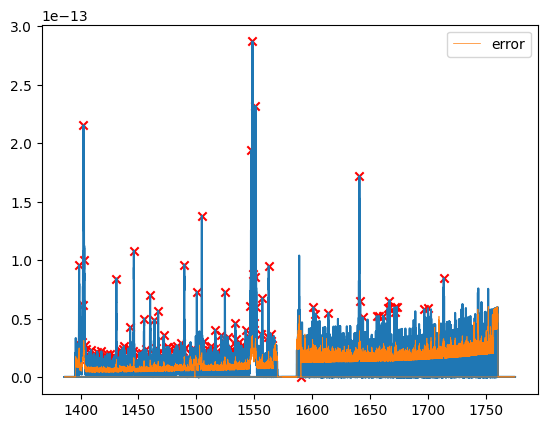

In [171]:
date_filter = all_spectra.spec_df['obsdate']=='2022-08-14'

flux = all_spectra.spec_df.loc[date_filter, 'flux'].values[0].value
fluxerr = all_spectra.spec_df.loc[date_filter, 'fluxerr'].values[0].value
wavelength = all_spectra.spec_df.loc[date_filter, 'wavelength'].values[0].value

peaks, _ = find_peaks(flux, height=fluxerr*2, distance=50)
#print(peaks)
plt.plot(wavelength, flux)
plt.scatter(wavelength[peaks], flux[peaks], c='red', marker='x')
#plt.hlines(np.mean(fluxerr[flux>0]), min(wavelength), max(wavelength), 'r','--')
plt.plot(wavelength, fluxerr, lw=0.5, label='error')
plt.legend()
#plt.xlim(left=1390)
plt.show()

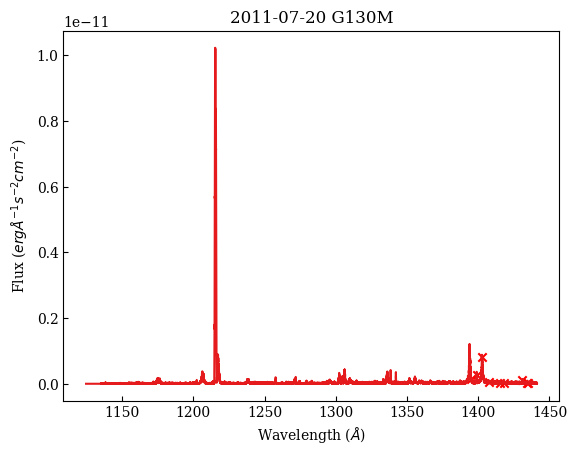

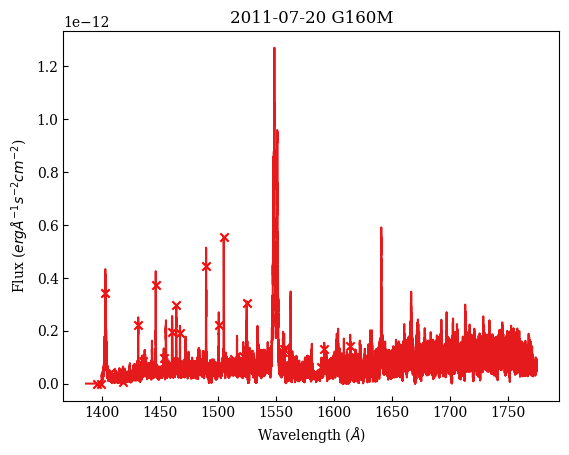

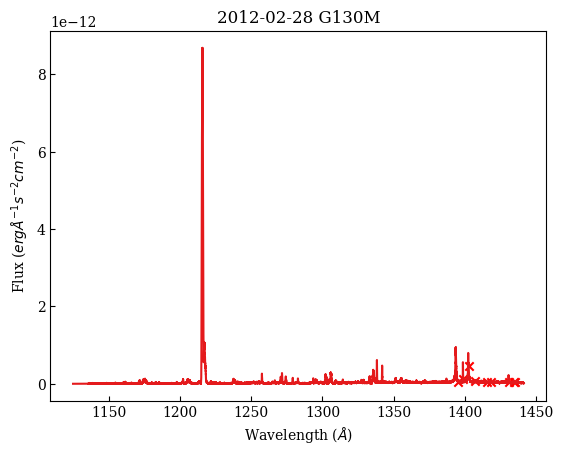

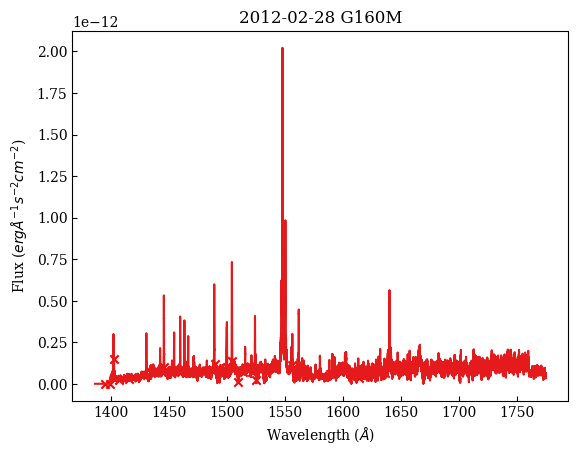

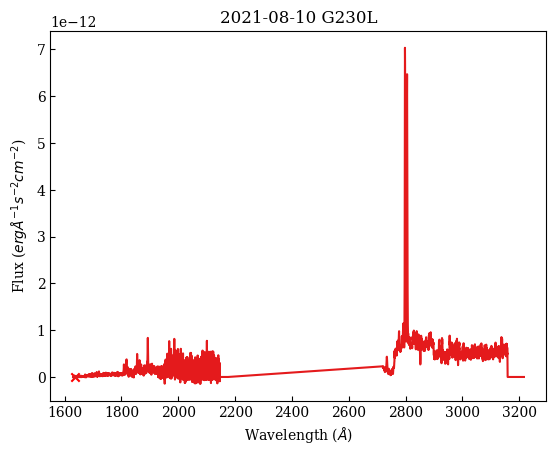

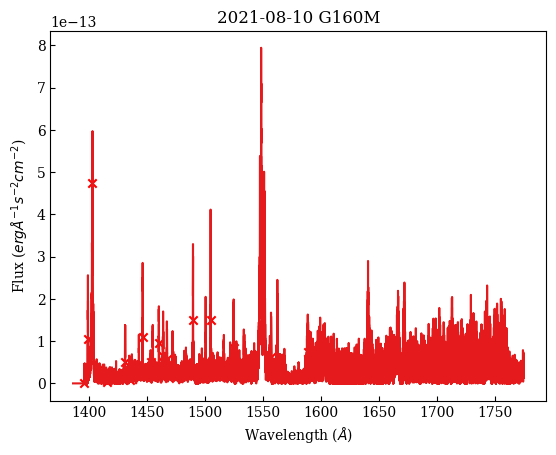

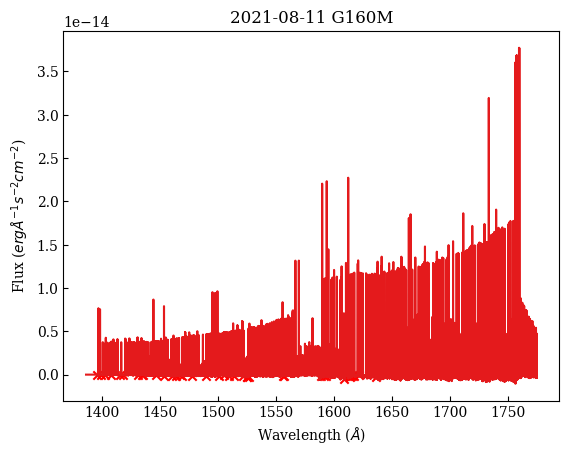

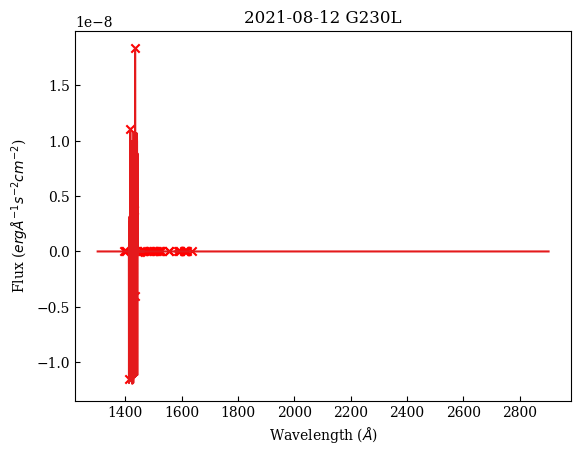

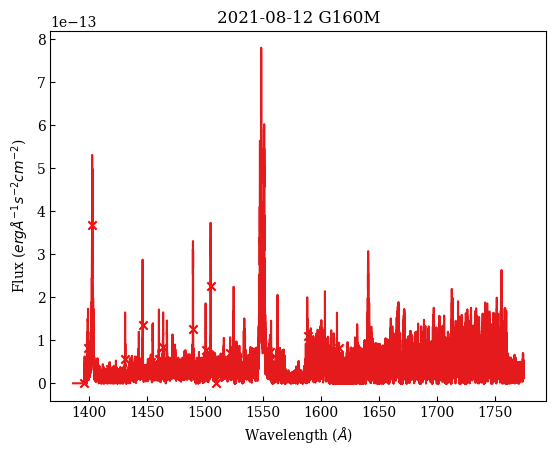

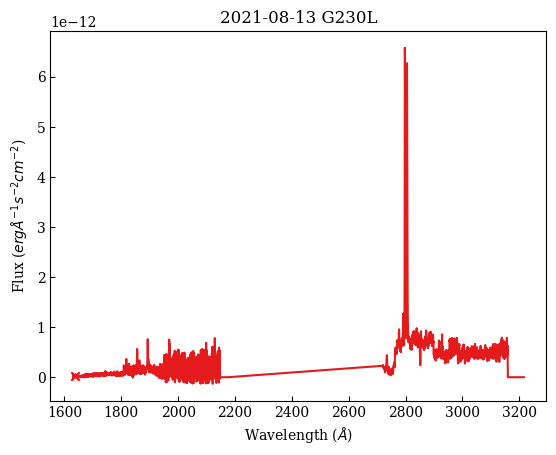

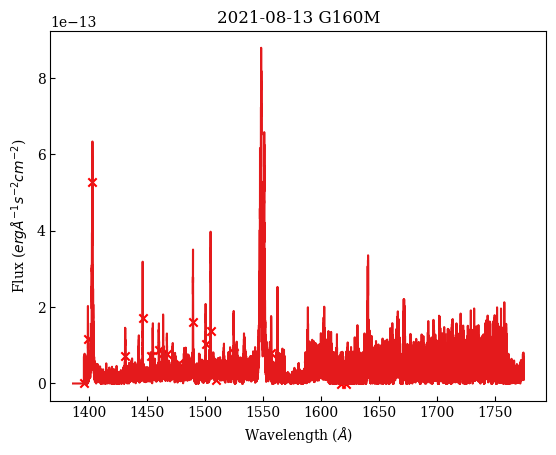

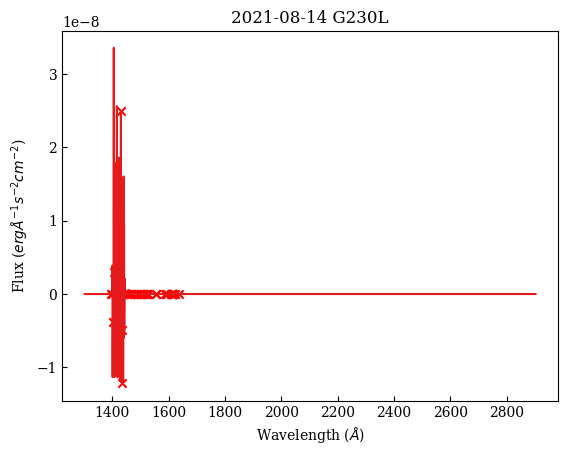

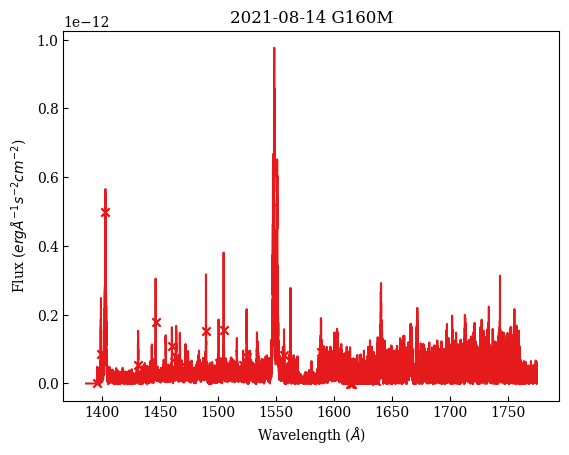

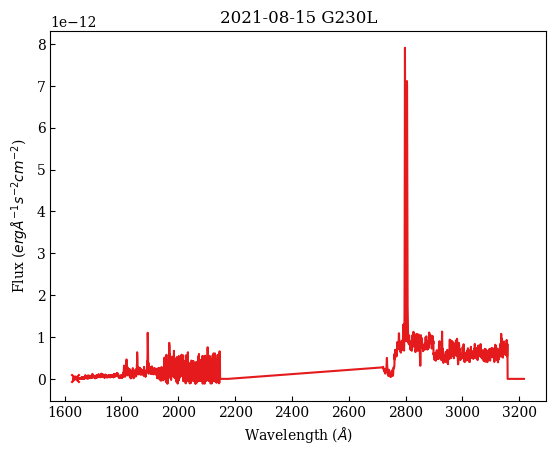

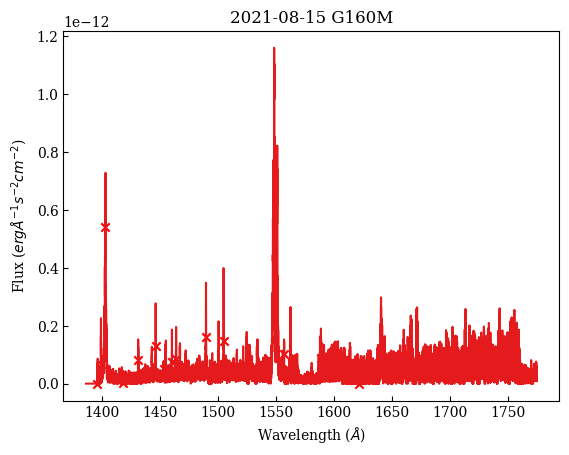

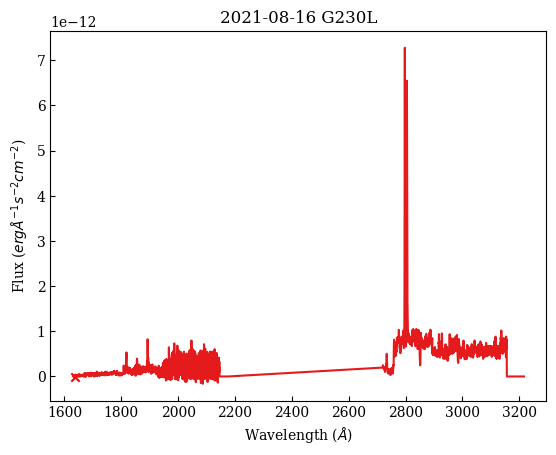

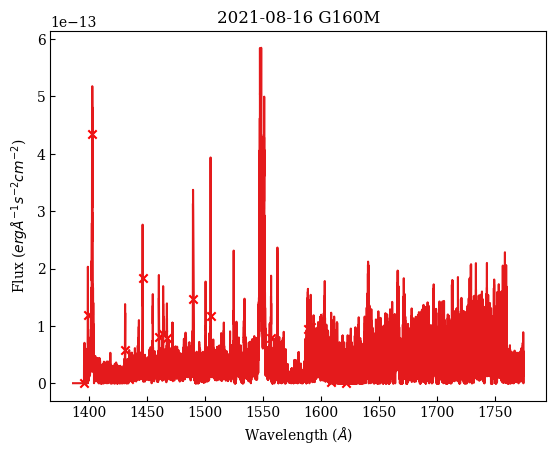

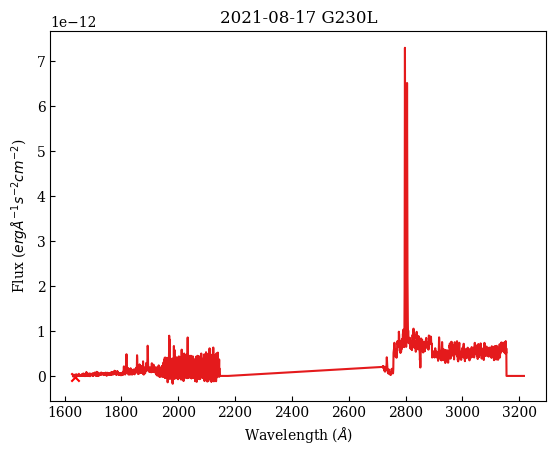

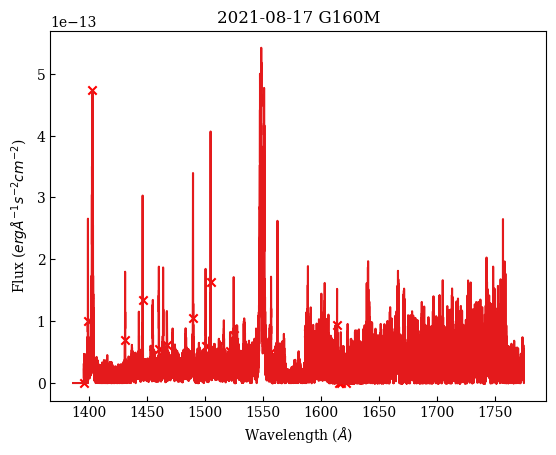

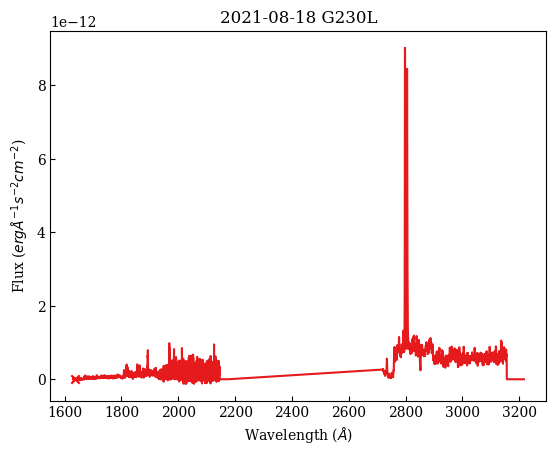

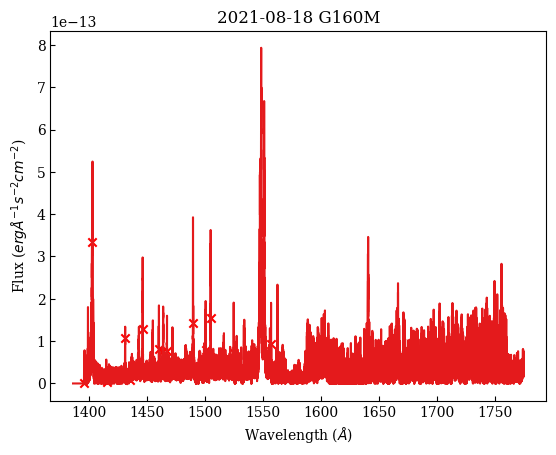

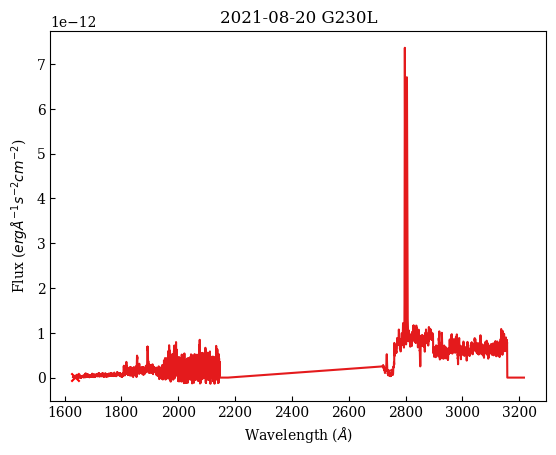

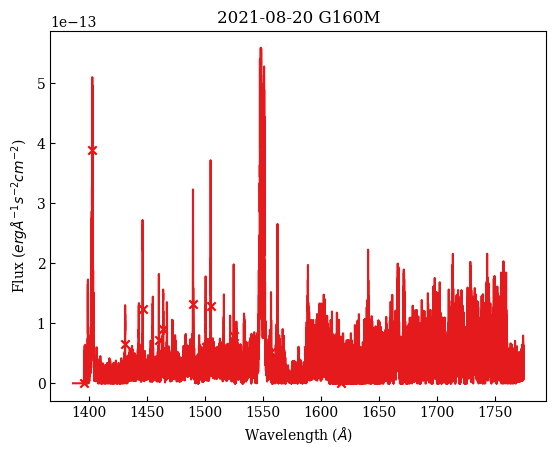

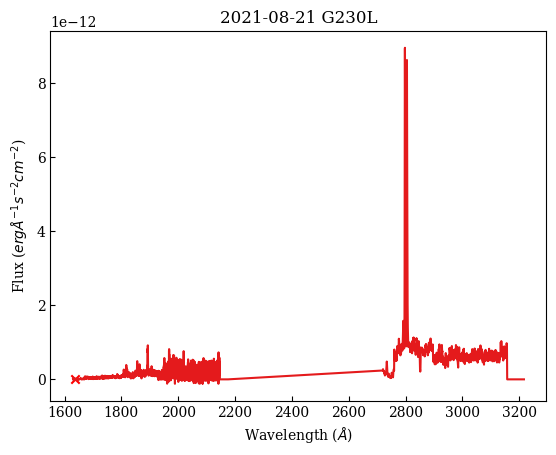

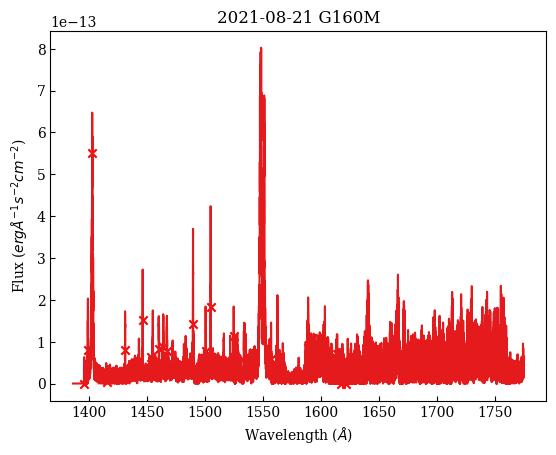

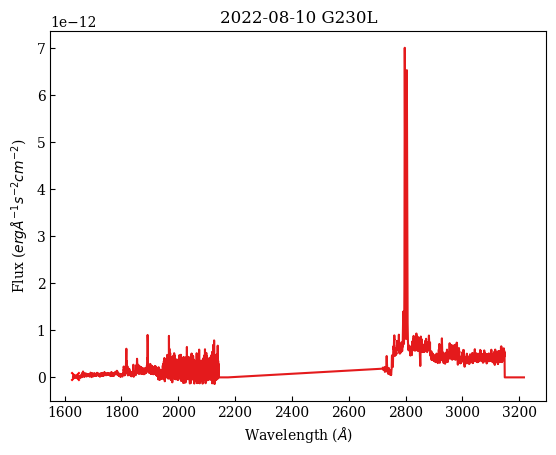

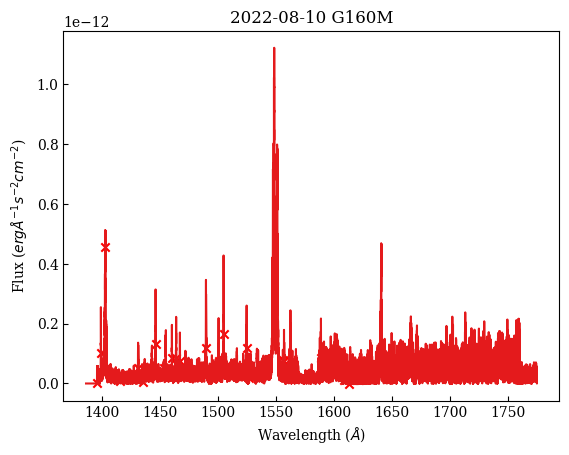

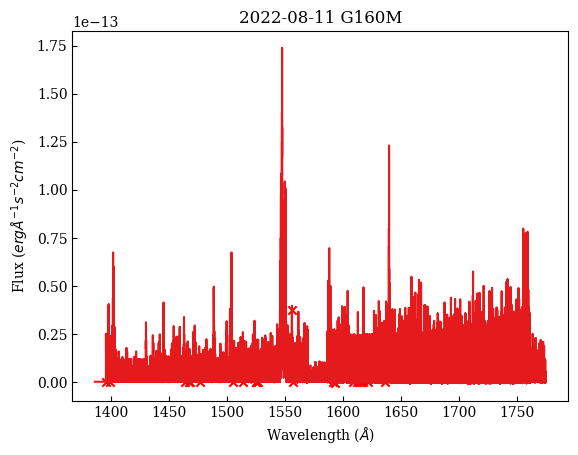

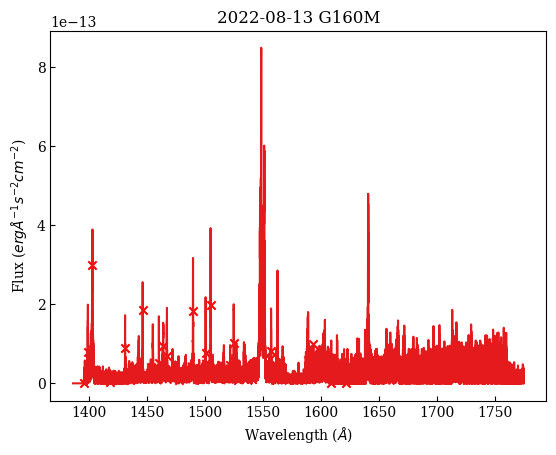

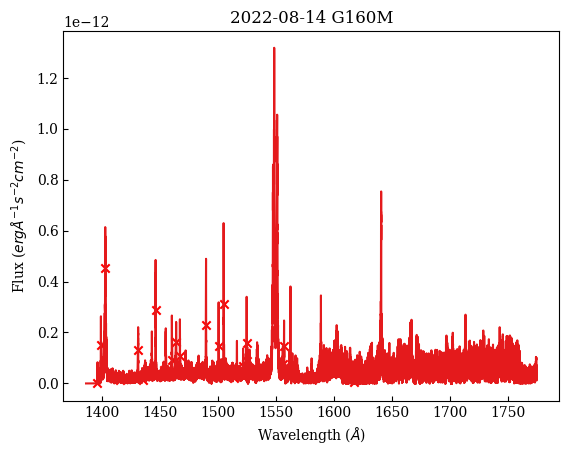

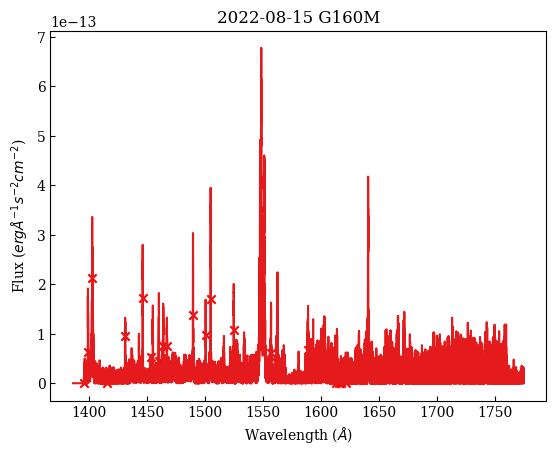

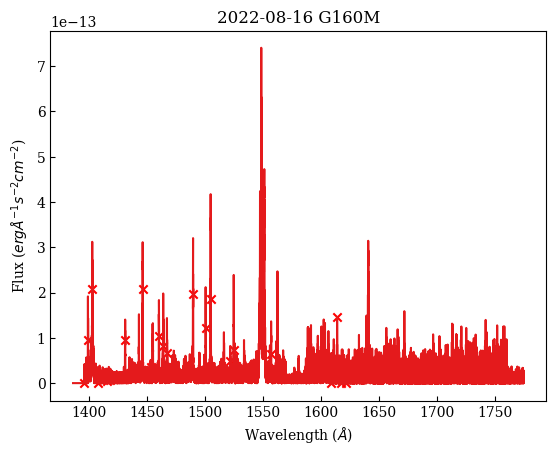

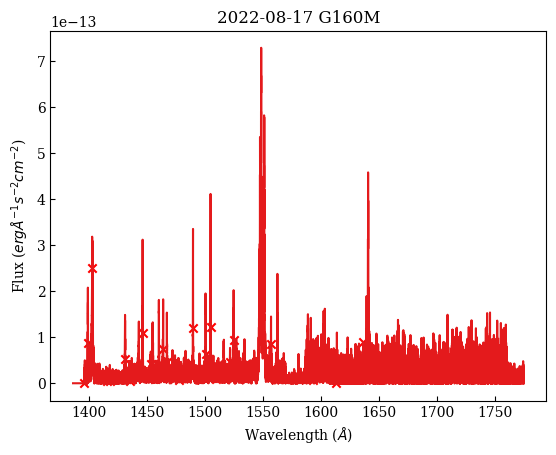

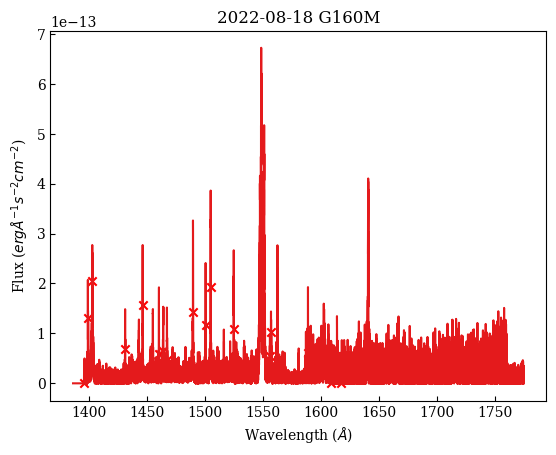

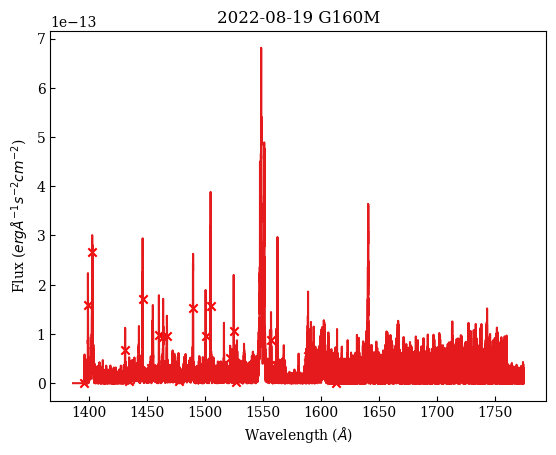

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f60402d15e0>>
Traceback (most recent call last):
  File "/mnt/c/Users/Prerana Kottapalli/Documents/GitHub/scripts_by_me/research24/astrotest/astro-venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


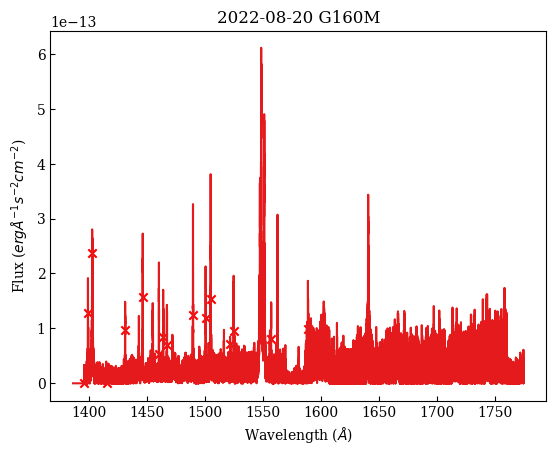

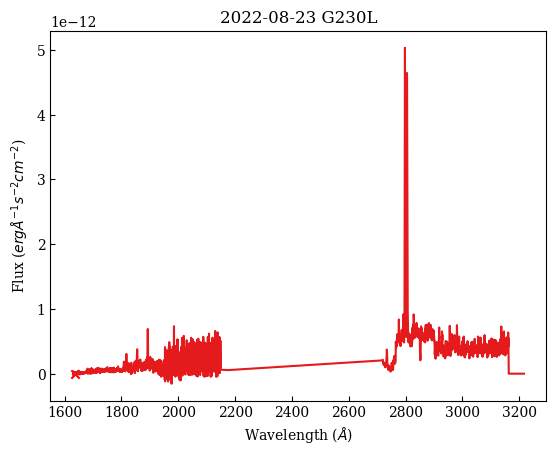

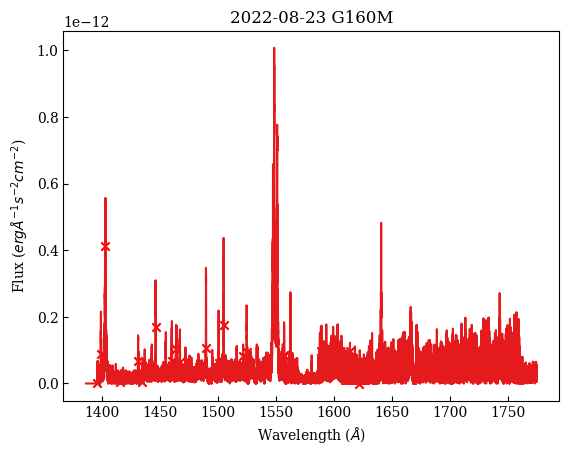

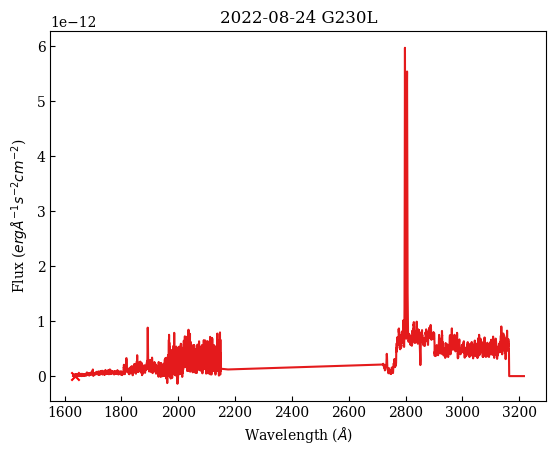

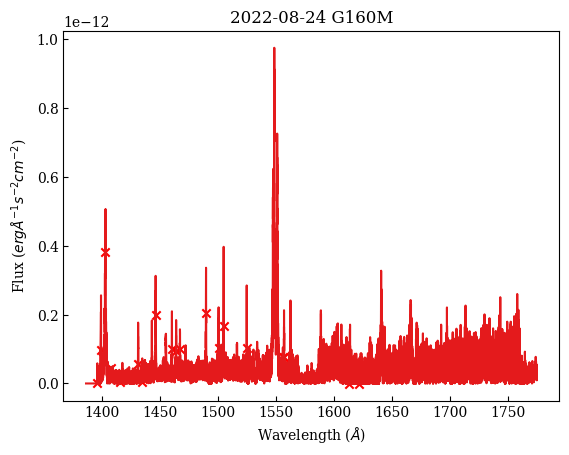

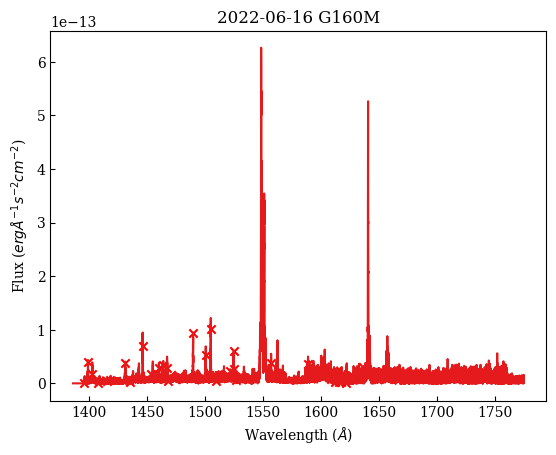

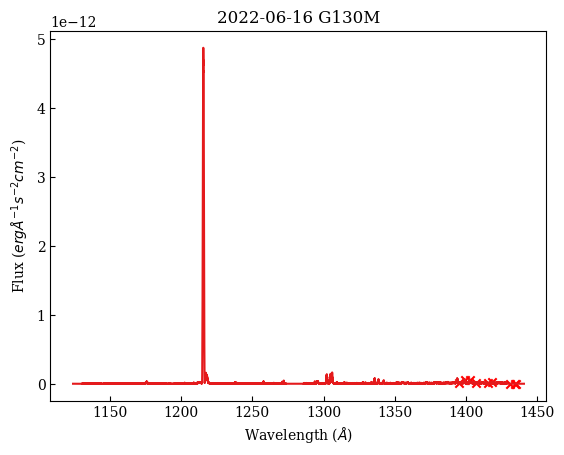

In [32]:
for _, row in stacked_df.iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.scatter(row['wavelength'][row['H2line_idx']], row['flux'][row['H2line_idx']], c='r', marker='x')
    plt.title(row['obsdate']+' '+row['filter'])
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
    plt.show()

# Now investigate individual lines

In [21]:
stacked_df = stacked_df[stacked_df['filter']!='G230L']
stacked_df = stacked_df[stacked_df["[nu', J']"].notna() & (stacked_df["[nu', J']"].apply(len) > 0)] #remove the spectra (coadded for one observation date) that don't have any H2 lines
stacked_df

obsdate filter                                         wavelength  \
0   2021-08-13  G160M  [1385.9931276253203 Angstrom, 1386.00536736705...   
3   2021-08-10  G160M  [1421.254196584923 Angstrom, 1421.266445181324...   
4   2021-08-18  G160M  [1421.250438441241 Angstrom, 1421.262687005296...   
5   2022-06-16  G160M  [1421.3367712210866 Angstrom, 1421.34902052907...   
6   2021-08-15  G160M  [1421.251682067404 Angstrom, 1421.263930642086...   
7   2022-08-11  G160M  [1421.254063552068 Angstrom, 1421.266312147713...   
8   2022-08-24  G160M  [1421.2488942629827 Angstrom, 1421.26114281391...   
9   2022-08-16  G160M  [1385.9917161124404 Angstrom, 1386.00395584173...   
10  2021-08-20  G160M  [1385.9903407572133 Angstrom, 1386.00258047415...   
11  2011-07-20  G160M  [1421.2426308057047 Angstrom, 1421.25487447368...   
12  2021-08-11  G160M  [1385.9941396590698 Angstrom, 1386.00637941009...   
14  2011-07-20  G130M  [1134.4087919542987 Angstrom, 1134.41875630458...   
15  2022-08-23  G160M  [1385.9896587703408 Angstrom, 1386.00189848125...   
16  2012-02-28  G160M  [1421.484376179013 Angstrom, 1421.496621929407...   
17  2012-02-28  G130M  [1124.9096635174221 Angstrom, 1124.91962690073...   
18  2021-08-16  G160M  [1385.9916804390439 Angstrom, 1386.00392016811...   
19  2021-08-21  G160M  [1385.9900462627913 Angstrom, 1386.00228597737...   
20  2022-08-19  G160M  [1385.9906740586073 Angstrom, 1386.00291377859...   
21  2021-08-12  G160M  [1385.9934968299058 Angstrom, 1386.00573657483...   
22  2022-08-15  G160M  [1385.9921428581877 Angstrom, 1386.00438259114...   
24  2021-08-14  G160M  [1421.2521631419022 Angstrom, 1421.26441172082...   
25  2022-08-10  G160M  [1385.9951835939507 Angstrom, 1386.00742335376...   
26  2022-06-16  G130M  [1124.1220811272192 Angstrom, 1124.13204848542...   
27  2022-08-14  G160M  [1385.9929259052471 Angstrom, 1386.00516564510...   
34  2022-08-18  G160M  [1421.2504525805757 Angstrom, 1421.26270114460...   
35  2021-08-17  G160M  [1385.9912497641506 Angstrom, 1386.00348948963...   
37  2022-08-13  G160M  [1421.2530339201037 Angstrom, 1421.26528250643...   
39  2022-08-17  G160M  [1421.250823324304 Angstrom, 1421.263071891649...   
40  2022-08-20  G160M  [1421.249797536383 Angstrom, 1421.262046095076...   

                                                 flux  \
0   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
3   [4.736898099985594e-15 erg / (Angstrom s cm2),...   
4   [8.536568923043122e-15 erg / (Angstrom s cm2),...   
5   [8.842805948548497e-16 erg / (Angstrom s cm2),...   
6   [5.668530234803062e-15 erg / (Angstrom s cm2),...   
7   [-2.957552869772527e-17 erg / (Angstrom s cm2)...   
8   [9.00888619710672e-15 erg / (Angstrom s cm2), ...   
9   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
10  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
11  [7.428045243004162e-15 erg / (Angstrom s cm2),...   
12  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
14  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
15  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
16  [1.9402935879202436e-14 erg / (Angstrom s cm2)...   
17  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
18  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
19  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
20  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
21  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
22  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
24  [8.965422452464702e-15 erg / (Angstrom s cm2),...   
25  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
26  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
27  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
34  [5.921033197360536e-15 erg / (Angstrom s cm2),...   
35  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
37  [9.827029141049102e-15 erg / (Angstrom s cm2),...   
39  [4.421725329470133e-15 erg / (Angstrom s cm2),...   
40  [1.0880142169956368e-14 erg / (Angstrom s cm2)...   

               

In [22]:
line_df = all_spectra.get_lines(stacked_df) #rearrange df by progressions, not obsdate
line_df

transition  labline     obsdate  \
0        [4,4]  1477.05  2021-08-13   
1        [4,4]  1526.55  2021-08-13   
2        [4,4]  1613.72  2021-08-13   
3        [4,4]  1477.05  2021-08-10   
4        [4,4]  1526.55  2021-08-10   
..         ...      ...         ...   
933     [4,13]  1613.99  2022-08-13   
934     [4,13]  1509.45  2022-08-17   
935     [4,13]  1613.99  2022-08-17   
936     [4,13]  1509.45  2022-08-20   
937     [4,13]  1613.99  2022-08-20   

                                            wavelength  \
0    [1475.2086051454871 Angstrom, 1475.22084488722...   
1    [1524.7183604711936 Angstrom, 1524.73060021293...   
2    [1611.8861260101742 Angstrom, 1611.89837357597...   
3    [1475.209263732277 Angstrom, 1475.221512328678...   
4    [1524.7180903859896 Angstrom, 1524.73033898239...   
..                                                 ...   
933  [1613.0658958944252 Angstrom, 1613.07684411166...   
934  [1507.6154716741673 Angstrom, 1507.62772024151...   
935  [1613.0742537383057 Angstrom, 1613.07563651494...   
936  [1507.6143848822758 Angstrom, 1507.62663344096...   
937  [1613.0731689131035 Angstrom, 1613.07447523089...   

                                                  flux  \
0    [2.5015368232469917e-14 erg / (Angstrom s cm2)...   
1    [5.904054594848872e-14 erg / (Angstrom s cm2),...   
2    [-1.3593035183282262e-16 erg / (Angstrom s cm2...   
3    [7.702630936445048e-15 erg / (Angstrom s cm2),...   
4    [4.158464854053475e-14 erg / (Angstrom s cm2),...   
..                                                 ...   
933  [2.157058192921567e-14 erg / (Angstrom s cm2),...   
934  [7.198513934836873e-15 erg / (Angstrom s cm2),...   
935  [7.152474306524827e-15 erg / (Angstrom s cm2),...   
936  [1.5576228906582513e-14 erg / (Angstrom s cm2)...   
937  [2.2029928509684792e-15 erg / (Angstrom s cm2)...   

                                               fluxerr  
0    [1.3718620241972999e-14 erg / (Angstrom s cm2)...  
1    [1.774906203198533e-14 erg / (Angstrom s cm2),...  
2    [1.7157493300608637e-14 erg / (Angstrom s cm2)...  
3    [1.0231216430802162e-14 erg / (Angstrom s cm2)...  
4    [1.5595290892831725e-14 erg / (Angstrom s cm2)...  
..                                                 ...  
933  [1.9067865041433635e-14 erg / (Angstrom s cm2)...  
934  [1.0570037061377894e-14 erg / (Angstrom s cm2)...  
935  [1.480849070584274e-14 erg / (Angstrom s cm2),...  
936  [1.1738627437998172e-14 erg / (Angstrom s cm2)...  
937  [1.3425367504876268e-14 erg / (Angstrom s cm2)...  

[938 rows x 6 columns]

# Look for contaminated lines in the [0,1], [0,2], [1,4], [1,7] transitions

{'[0,3]', '[2,12]', '[0,2]', '[1,7]', '[4,13]', '[0,1]', '[3,16]', '[2,15]', '[1,4]', '[3,0]', '[4,4]', '[3,13]'}

In [23]:
exclude_lines = {
    "[0,1]": {
        "dates": ["2022-08-11", "2022-08-24", "2011-07-20", "2021-08-11", "2021-08-11", "2021-08-11", "2011-07-20", "2012-02-28", "2012-02-28", "2021-08-16", "2022-08-14"],
        "wavelengths": [1460.17, 1521.59, 1521.59, 1398.95, 1460.17, 1521.59, 1398.95, 1521.59, 1398.95, 1521.59, 1521.59]
    },
    "[0,2]": {
        "dates": ["2022-06-16", "2022-08-11", "2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "2022-08-10", "2022-08-13"],
        "wavelengths": [1525.15, 1463.83, 1525.15, 1402.65, 1463.83, 1525.15, 1402.65, 1525.15, 1525.15]
    },
    "[1,4]": {
        "dates": ["2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11"],
        "wavelengths": [1431.01, 1431.01, 1446.12, 1489.57, 1504.76]
    },
    "[1,7]": {
        "dates": ["All", "All", "2022-08-11", "2022-08-11", "2011-07-20", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "2021-08-21", "2022-08-18"],
        "wavelengths": [1556.87, 1524.65, 1467.08, 1500.45, 1556.87, 1467.08, 1500.45, 1524.65, 1556.87, 1556.87, 1556.87, 1556.87]
    },
    "[2,12]": {
        'dates': ['2021-08-10', '2021-08-18', '2021-08-18', '2022-06-16', '2022-06-16', '2022-08-1', '2022-08-11', '2022-08-11', '2021-08-20', '2011-07-20', '2021-08-11', '2021-08-11', '2021-08-11', '2012-02-28', '2021-08-16', '2021-08-12', '2022-08-10', "All"],
        "wavelengths": [1453.10, 1555.89, 1588.8, 1453.1, 1555.89, 1453.1, 1555.89, 1588.8, 1555.89, 1588.8, 1453.1, 1555.89, 1588.8, 1555.89, 1453.1, 1555.89, 1453.1, 1434.54]
    }
}

In [24]:
# exclude bad/contaminated lines from coadding
bad_transitions = ['[3,0]', '[4,13]', '[3,13]', '[4,4]', '[2,15]', '[3,16]', '[4,0]']
bad_transitions_mask = ~line_df['transition'].isin(bad_transitions)
line_df_good = line_df[bad_transitions_mask]

contaminated = []
for transition in exclude_lines.keys():
    dates = exclude_lines[transition]['dates']
    lines_ex = exclude_lines[transition]['wavelengths']
    for d, w in zip(dates, lines_ex):
        if d == "All":
            exclude_idx = line_df_good.index[(line_df_good['transition']==transition)&(line_df_good['labline']==w)].tolist()
        else:
            exclude_idx = line_df_good.index[(line_df_good['transition']==transition)&(line_df_good['labline']==w)&(line_df_good['obsdate']==d)].tolist()
        contaminated.extend(exclude_idx)

line_df_good = line_df_good.drop(index=contaminated)

line_df_good = line_df_good[line_df_good['obsdate']!='2021-08-11']
line_df_good

transition  labline     obsdate  \
305      [0,1]  1398.95  2021-08-13   
306      [0,1]  1460.17  2021-08-13   
307      [0,1]  1521.59  2021-08-13   
308      [0,1]  1460.17  2021-08-10   
309      [0,1]  1521.59  2021-08-10   
..         ...      ...         ...   
859      [1,7]  1500.45  2022-08-13   
862      [1,7]  1467.08  2022-08-17   
863      [1,7]  1500.45  2022-08-17   
866      [1,7]  1467.08  2022-08-20   
867      [1,7]  1500.45  2022-08-20   

                                            wavelength  \
305  [1397.1190528641503 Angstrom, 1397.13129260588...   
306  [1458.3300012903205 Angstrom, 1458.34224103205...   
307  [1519.7490253260178 Angstrom, 1519.76126506775...   
308  [1458.330697891402 Angstrom, 1458.342946487803...   
309  [1519.7574088434974 Angstrom, 1519.76965743989...   
..                                                 ...   
859  [1498.6151051991467 Angstrom, 1498.62735378547...   
862  [1465.2476772276807 Angstrom, 1465.25992579502...   
863  [1498.6127746755644 Angstrom, 1498.62502324290...   
866  [1465.2466203624285 Angstrom, 1465.25886892112...   
867  [1498.6116942427593 Angstrom, 1498.62394280145...   

                                                  flux  \
305  [-3.990932712098075e-17 erg / (Angstrom s cm2)...   
306  [2.7283172030593473e-14 erg / (Angstrom s cm2)...   
307  [2.897223054190684e-14 erg / (Angstrom s cm2),...   
308  [1.936029444039974e-14 erg / (Angstrom s cm2),...   
309  [1.0273126895568653e-14 erg / (Angstrom s cm2)...   
..                                                 ...   
859  [5.06012696953567e-15 erg / (Angstrom s cm2), ...   
862  [3.464097535746793e-14 erg / (Angstrom s cm2),...   
863  [1.538006850240574e-14 erg / (Angstrom s cm2),...   
866  [1.9452051516556116e-14 erg / (Angstrom s cm2)...   
867  [1.0214550728957373e-14 erg / (Angstrom s cm2)...   

                                               fluxerr  
305  [1.1262247451559499e-14 erg / (Angstrom s cm2)...  
306  [1.171887556245226e-14 erg / (Angstrom s cm2),...  
307  [1.3885255401630601e-14 erg / (Angstrom s cm2)...  
308  [1.0745947545104029e-14 erg / (Angstrom s cm2)...  
309  [1.0805033469100896e-14 erg / (Angstrom s cm2)...  
..                                                 ...  
859  [8.226201313860405e-15 erg / (Angstrom s cm2),...  
862  [1.3213865306324794e-14 erg / (Angstrom s cm2)...  
863  [1.0471781856340428e-14 erg / (Angstrom s cm2)...  
866  [1.118918279375072e-14 erg / (Angstrom s cm2),...  
867  [9.474044528896322e-15 erg / (Angstrom s cm2),...  

[384 rows x 6 columns]

# Drop Duplicates

In [25]:
line_df_good[~line_df_good.duplicated(['obsdate', 'transition', 'labline'])]

transition  labline     obsdate  \
305      [0,1]  1398.95  2021-08-13   
306      [0,1]  1460.17  2021-08-13   
307      [0,1]  1521.59  2021-08-13   
308      [0,1]  1460.17  2021-08-10   
309      [0,1]  1521.59  2021-08-10   
..         ...      ...         ...   
859      [1,7]  1500.45  2022-08-13   
862      [1,7]  1467.08  2022-08-17   
863      [1,7]  1500.45  2022-08-17   
866      [1,7]  1467.08  2022-08-20   
867      [1,7]  1500.45  2022-08-20   

                                            wavelength  \
305  [1397.1190528641503 Angstrom, 1397.13129260588...   
306  [1458.3300012903205 Angstrom, 1458.34224103205...   
307  [1519.7490253260178 Angstrom, 1519.76126506775...   
308  [1458.330697891402 Angstrom, 1458.342946487803...   
309  [1519.7574088434974 Angstrom, 1519.76965743989...   
..                                                 ...   
859  [1498.6151051991467 Angstrom, 1498.62735378547...   
862  [1465.2476772276807 Angstrom, 1465.25992579502...   
863  [1498.6127746755644 Angstrom, 1498.62502324290...   
866  [1465.2466203624285 Angstrom, 1465.25886892112...   
867  [1498.6116942427593 Angstrom, 1498.62394280145...   

                                                  flux  \
305  [-3.990932712098075e-17 erg / (Angstrom s cm2)...   
306  [2.7283172030593473e-14 erg / (Angstrom s cm2)...   
307  [2.897223054190684e-14 erg / (Angstrom s cm2),...   
308  [1.936029444039974e-14 erg / (Angstrom s cm2),...   
309  [1.0273126895568653e-14 erg / (Angstrom s cm2)...   
..                                                 ...   
859  [5.06012696953567e-15 erg / (Angstrom s cm2), ...   
862  [3.464097535746793e-14 erg / (Angstrom s cm2),...   
863  [1.538006850240574e-14 erg / (Angstrom s cm2),...   
866  [1.9452051516556116e-14 erg / (Angstrom s cm2)...   
867  [1.0214550728957373e-14 erg / (Angstrom s cm2)...   

                                               fluxerr  
305  [1.1262247451559499e-14 erg / (Angstrom s cm2)...  
306  [1.171887556245226e-14 erg / (Angstrom s cm2),...  
307  [1.3885255401630601e-14 erg / (Angstrom s cm2)...  
308  [1.0745947545104029e-14 erg / (Angstrom s cm2)...  
309  [1.0805033469100896e-14 erg / (Angstrom s cm2)...  
..                                                 ...  
859  [8.226201313860405e-15 erg / (Angstrom s cm2),...  
862  [1.3213865306324794e-14 erg / (Angstrom s cm2)...  
863  [1.0471781856340428e-14 erg / (Angstrom s cm2)...  
866  [1.118918279375072e-14 erg / (Angstrom s cm2),...  
867  [9.474044528896322e-15 erg / (Angstrom s cm2),...  

[380 rows x 6 columns]

# Coadd progressions

In [47]:
#convert both lines to velocity space first
df = line_df_good
res = {}
columns = ['transition', 'obsdate']
combinations = df[columns].drop_duplicates()
for _, row in combinations.iterrows():
    unique_values = [row[col] for col in columns]
    # Filter the group
    mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
    group = df[mask]
    
    coadded_flux = group['flux'].iloc[0].value
    templatev = all_spectra.radial_velocity(group['wavelength'].iloc[0],
                                            group['labline'].iloc[0]).value
    coadd_error = group['fluxerr'].iloc[0].value
    for _, row in group.iterrows():
        velocity = all_spectra.radial_velocity(row['wavelength'], row['labline']).value
        resampled_flux = np.interp(templatev, velocity, row['flux'])
        resampled_fluxerr = np.interp(templatev, velocity, row['fluxerr'])
        coadded_flux += resampled_flux.value
        coadd_error += resampled_fluxerr.value

    N = len(group)
    coadded_flux = coadded_flux/N
    coadded_error = np.sqrt(coadd_error)/N
    spec_dict = {'wavelength': group['wavelength'].iloc[0], 'flux':coadded_flux*all_spectra.flux_units, 'fluxerr': coadded_error*all_spectra.flux_units, 'velocity': templatev*(u.km/u.s)}
    res[tuple(unique_values)] = spec_dict

prog_df = pd.DataFrame([
    {**dict(zip(columns, k)), **(v if v is not None else {})}
    for k, v in res.items()
])

prog_df

transition     obsdate                                         wavelength  \
0        [1,4]  2021-08-13  [1429.1749364730565 Angstrom, 1429.18717621479...   
1        [1,4]  2021-08-10  [1429.166789860108 Angstrom, 1429.179038456509...   
2        [1,4]  2021-08-18  [1429.1752593851513 Angstrom, 1429.18750794920...   
3        [1,4]  2022-06-16  [1429.1763283307753 Angstrom, 1429.18857763875...   
4        [1,4]  2021-08-15  [1429.1765098869735 Angstrom, 1429.18875846165...   
..         ...         ...                                                ...   
143      [1,7]  2022-08-18  [1465.247294574864 Angstrom, 1465.259543138893...   
144      [1,7]  2021-08-17  [1465.2434722702628 Angstrom, 1465.25571199574...   
145      [1,7]  2022-08-13  [1465.2377074418016 Angstrom, 1465.24995602813...   
146      [1,7]  2022-08-17  [1465.2476772276807 Angstrom, 1465.25992579502...   
147      [1,7]  2022-08-20  [1465.2466203624285 Angstrom, 1465.25886892112...   

                                                  flux  \
0    [1.0212622426769225e-11 erg / (Angstrom s cm2)...   
1    [2.1204332393292093e-12 erg / (Angstrom s cm2)...   
2    [3.819704110075195e-12 erg / (Angstrom s cm2),...   
3    [1.0710574610052635e-12 erg / (Angstrom s cm2)...   
4    [2.6251000643676404e-12 erg / (Angstrom s cm2)...   
..                                                 ...   
143  [4.981401165295615e-09 erg / (Angstrom s cm2),...   
144  [6.085927803874327e-12 erg / (Angstrom s cm2),...   
145  [5.685241652857854e-09 erg / (Angstrom s cm2),...   
146  [6.998903464278616e-09 erg / (Angstrom s cm2),...   
147  [4.290194002908568e-09 erg / (Angstrom s cm2),...   

                                               fluxerr  \
0    [1.552271830759236e-07 erg / (Angstrom s cm2),...   
1    [1.3921301551545652e-07 erg / (Angstrom s cm2)...   
2    [1.4855372892241344e-07 erg / (Angstrom s cm2)...   
3    [6.542718057498944e-08 erg / (Angstrom s cm2),...   
4    [1.4141290742283215e-07 erg / (Angstrom s cm2)...   
..                                                 ...   
143  [6.274900388725293e-07 erg / (Angstrom s cm2),...   
144  [1.8132720986039175e-07 erg / (Angstrom s cm2)...   
145  [5.21553693525452e-07 erg / (Angstrom s cm2), ...   
146  [6.604276253940702e-07 erg / (Angstrom s cm2),...   
147  [6.241571008921937e-07 erg / (Angstrom s cm2),...   

                                              velocity  
0    [-384.4405037900063 km / s, -381.8763132808297...  
1    [-386.14719565112097 km / s, -383.581150115345...  
2    [-384.37285463966987 km / s, -381.806815880229...  
3    [-384.1489136217356 km / s, -381.5827190114321...  
4    [-384.11087812308836 km / s, -381.544837137276...  
..                                                 ...  
143  [-374.5066827926253 km / s, -372.0037333164931...  
144  [-375.2877568251525 km / s, -372.7866134737521...  
145  [-376.46577853790075 km / s, -373.962824504214...  
146  [-374.4284890823653 km / s, -371.9255389287564...  
147  [-374.64445564977945 km / s, -372.141507264133...  

[148 rows x 6 columns]

# Diagnostics

In [131]:
def make_spectrum(row):
    spectrum = Spectrum1D(flux = row['flux'], spectral_axis=row['wavelength'], uncertainty=StdDevUncertainty(row['fluxerr']))
    #spectrum.spectral_axis.to(u.km/u.s, doppler_convention='optical', doppler_rest=row['labline']*u.AA)
    return spectrum

/tmp/ipykernel_3638824/2120184872.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


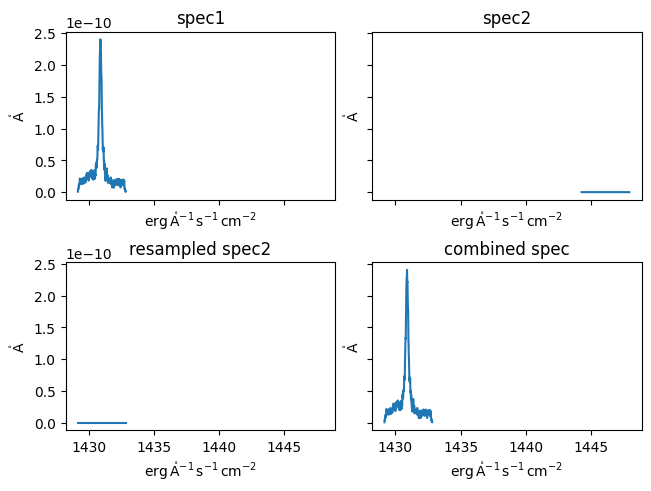

In [132]:
#Try checking what the wavelengths looks like once resampled, just try for two spectra.
resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
test = line_df_good[(line_df_good['obsdate']=='2022-08-20')&(line_df_good['transition']=='[1,4]')]
spec1 = make_spectrum(test.iloc[0])
spec2 = make_spectrum(test.iloc[1])
# spec1 = make_spectrum(stacked_df.iloc[0])
# spec2 = make_spectrum(stacked_df.iloc[1])

resampled_spec2 = resampler(spec2, spec1.spectral_axis)
#Once spec2 is resampled, the wavelengths of spec1 and spec2 are the same
combined_spec = spec1+resampled_spec2
fig, axs = plt.subplots(2,2,sharex=True, sharey=True, layout='constrained')

axs[0,0].plot(spec1.spectral_axis, spec1.flux)
axs[0,1].plot(spec2.spectral_axis, spec2.flux)
axs[1,0].plot(resampled_spec2.spectral_axis, resampled_spec2.flux)
axs[1,1].plot(combined_spec.spectral_axis, combined_spec.flux)

axs[0,0].set_title('spec1')
axs[0,1].set_title('spec2')
axs[1,0].set_title('resampled spec2')
axs[1,1].set_title('combined spec')

for ax in np.ravel(axs):
    ax.set_xlabel(u.format.Latex().to_string(spec1.flux.unit, fraction=False))
    ax.set_ylabel(u.format.Latex().to_string(spec1.spectral_axis.unit, fraction=False))
fig.show()

/tmp/ipykernel_3638824/3417691443.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


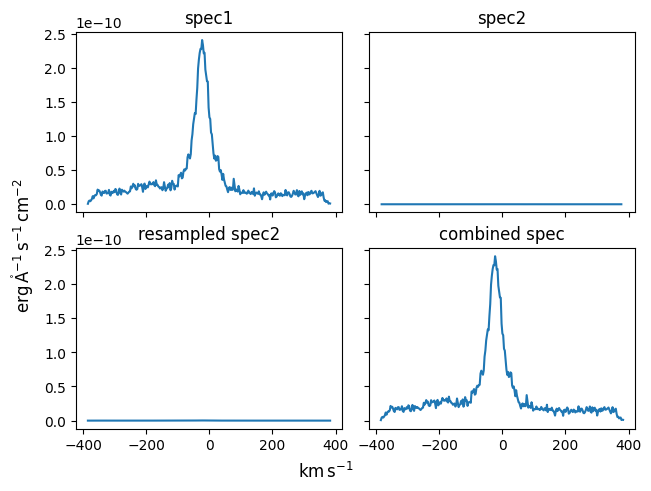

In [133]:
#convert both lines to velocity space first
spec1v = all_spectra.radial_velocity(test.iloc[0]['wavelength'], test.iloc[0]['labline'])
spec2v = all_spectra.radial_velocity(test.iloc[1]['wavelength'], test.iloc[1]['labline'])
spec1flux = test.iloc[0]['flux']
spec2flux = test.iloc[1]['flux']
spec1fluxerr = test.iloc[0]['fluxerr']
spec2fluxerr = test.iloc[1]['fluxerr']
#Then cross correlate to find how the second should be shifted to the first
f=interp1d(spec2v, spec2flux, kind='linear', fill_value=0, bounds_error=False)
resampled_spec2flux = f(spec1v) #This is then the extrapolated flux after resampling
resampled_spec2v = spec1v
#Then add the fluxes together
coadded_flux = spec1flux.value+resampled_spec2flux
coadded_velocity = spec1v

#Then propagate errors
error = np.sqrt(spec1fluxerr**2 + spec2fluxerr**2)

#plot
fig, axs = plt.subplots(2,2,sharex=True, sharey=True, layout='constrained')

axs[0,0].plot(spec1v, spec1flux)
axs[0,1].plot(spec2v, spec2flux)
axs[1,0].plot(resampled_spec2v, resampled_spec2flux)
axs[1,1].plot(coadded_velocity, coadded_flux)

axs[0,0].set_title('spec1')
axs[0,1].set_title('spec2')
axs[1,0].set_title('resampled spec2')
axs[1,1].set_title('combined spec')

#for ax in np.ravel(axs):
fig.supylabel(u.format.Latex().to_string(all_spectra.flux_units, fraction=False))
fig.supxlabel(u.format.Latex().to_string(u.km/u.s, fraction=False))
fig.show()

In [134]:
#coadd all spectral lines in the same progression for better SNR
prog_df = all_spectra.coaddwave(line_df_good, columns=['obsdate', 'transition'], velocity=True)
prog_df

obsdate transition                                         wavelength  \
0    2021-08-13      [0,3]  [1393.361452150926 Angstrom, 1393.373691892663...   
1    2021-08-10      [0,3]  [1466.5495060766177 Angstrom, 1466.56175467301...   
2    2021-08-18      [0,3]  [1466.5578768825458 Angstrom, 1466.57012544660...   
3    2022-06-16      [0,3]  [1466.54896698962 Angstrom, 1466.561216297604 ...   
4    2021-08-15      [0,3]  [1466.5469112432431 Angstrom, 1466.55915981792...   
..          ...        ...                                                ...   
143  2022-08-18      [0,2]  [1461.9891765429932 Angstrom, 1462.00142510702...   
144  2021-08-17      [0,2]  [1400.8135573247532 Angstrom, 1400.82579705023...   
145  2022-08-13      [0,2]  [1461.9918320635643 Angstrom, 1462.00408064989...   
146  2022-08-17      [0,2]  [1461.9895583139005 Angstrom, 1462.00180688124...   
147  2022-08-20      [0,2]  [1461.9885037500321 Angstrom, 1462.00075230872...   

                                                  flux  \
0    [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
1    [2.6582631463336287e-09 erg / (Angstrom s cm2)...   
2    [4.8598197746272346e-09 erg / (Angstrom s cm2)...   
3    [3.0463131741859097e-09 erg / (Angstrom s cm2)...   
4    [4.878058639523239e-09 erg / (Angstrom s cm2),...   
..                                                 ...   
143  [2.2513561216096542e-09 erg / (Angstrom s cm2)...   
144  [1.3876859730754809e-11 erg / (Angstrom s cm2)...   
145  [2.4956723648155793e-09 erg / (Angstrom s cm2)...   
146  [2.201810586421509e-09 erg / (Angstrom s cm2),...   
147  [3.864211045991475e-09 erg / (Angstrom s cm2),...   

                                               fluxerr  \
0    [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
1    [1.2825507804775605e-14 erg / (Angstrom s cm2)...   
2    [1.7402503061500313e-14 erg / (Angstrom s cm2)...   
3    [6.172714986437967e-15 erg / (Angstrom s cm2),...   
4    [1.7201545150234512e-14 erg / (Angstrom s cm2)...   
..                                                 ...   
143  [1.5227250916943796e-14 erg / (Angstrom s cm2)...   
144  [1.536465089819808e-14 erg / (Angstrom s cm2),...   
145  [1.5566065314701958e-14 erg / (Angstrom s cm2)...   
146  [1.510995361024994e-14 erg / (Angstrom s cm2),...   
147  [1.7802805813204683e-14 erg / (Angstrom s cm2)...   

                                              velocity  
0    [-395.05646418043307 km / s, -392.426459693181...  
1    [-375.76270420315456 km / s, -373.261981083160...  
2    [-374.05368651398624 km / s, -371.552969997834...  
3    [-375.87276639103504 km / s, -373.371897991441...  
4    [-376.29247590923217 km / s, -373.791757223386...  
..                                                 ...  
143  [-377.0007370528645 km / s, -374.4922305204442...  
144  [-392.50822627764313 km / s, -389.892194204112...  
145  [-376.45688630566787 km / s, -373.948375205466...  
146  [-376.9225503517754 km / s, -374.4140431403020...  
147  [-377.13852508530863 km / s, -374.630019645723...  

[148 rows x 6 columns]

# Plot lines

In [64]:
def mask_df(df, mask_dict):
    columns = mask_dict.keys()
    values = mask_dict.values()
    mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, values)])
    filtered = df[mask]
    return filtered

In [68]:
#coadd_lines
mask_dict = {'transition':'[1,7]', 'obsdate':'2022-08-20'}
mask_df(line_df, mask_dict)

transition  labline     obsdate  \
934      [1,7]  1467.08  2022-08-20   
935      [1,7]  1500.45  2022-08-20   
936      [1,7]  1524.65  2022-08-20   
937      [1,7]  1556.87  2022-08-20   

                                            wavelength  \
934  [1465.2466203624285 Angstrom, 1465.25886892112...   
935  [1498.6116942427593 Angstrom, 1498.62394280145...   
936  [1522.8148462205615 Angstrom, 1522.82709477925...   
937  [1555.0285555837297 Angstrom, 1555.04080414242...   

                                                  flux  \
934  [1.3728645516769043e-07 erg / (Angstrom s cm2)...   
935  [1.0214550728957373e-14 erg / (Angstrom s cm2)...   
936  [1.9536449806269816e-14 erg / (Angstrom s cm2)...   
937  [1.1901472122490107e-14 erg / (Angstrom s cm2)...   

                                               fluxerr  
934  [2.5133132743829412e-11 erg / (Angstrom s cm2)...  
935  [9.474044528896322e-15 erg / (Angstrom s cm2),...  
936  [1.3653116875744486e-14 erg / (Angstrom s cm2)...  
937  [1.3175870479928446e-14 erg / (Angstrom s cm2)...

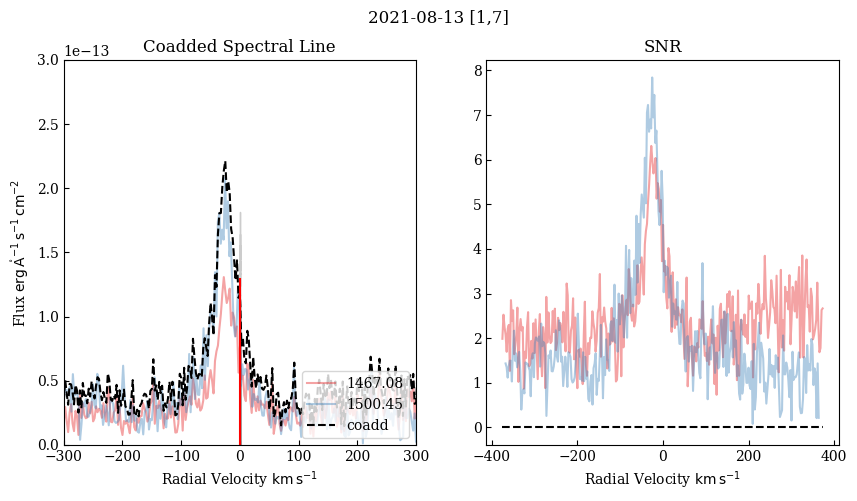

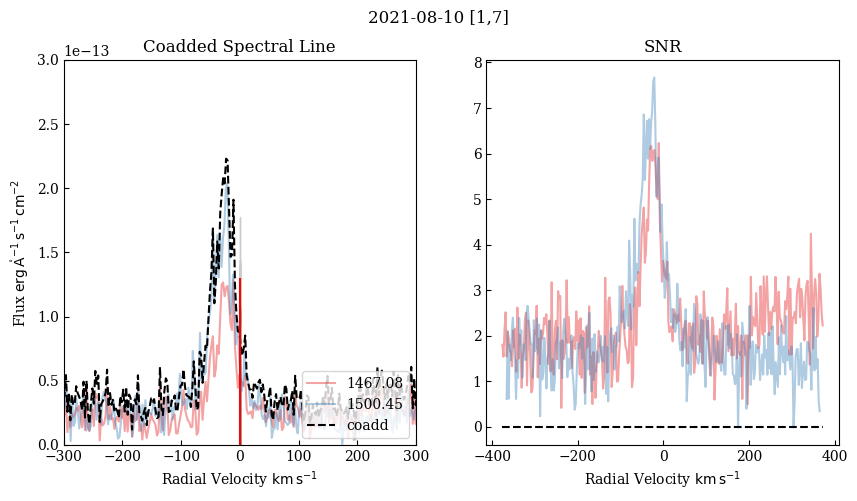

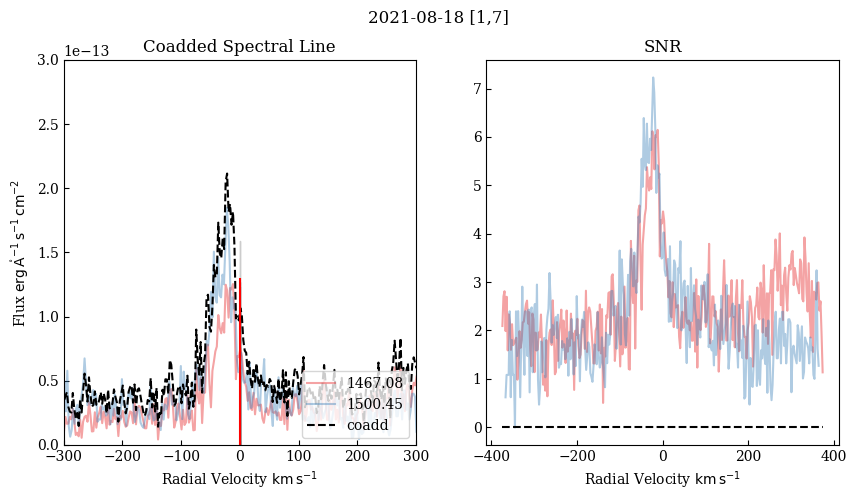

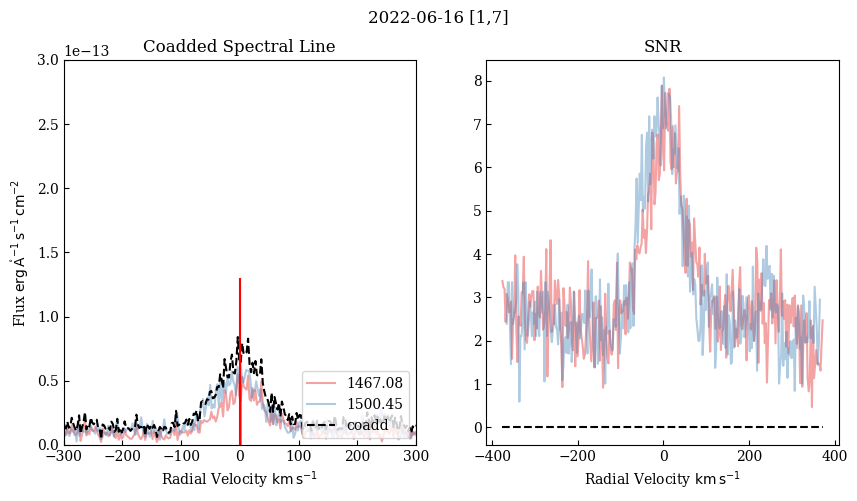

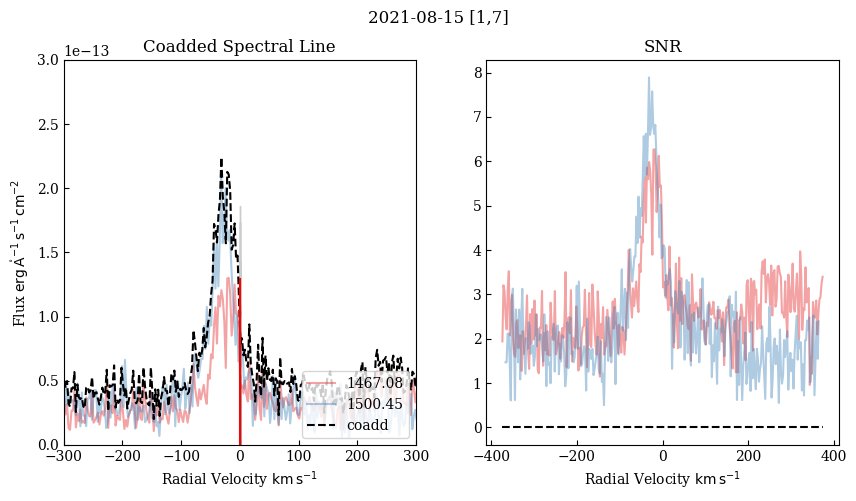

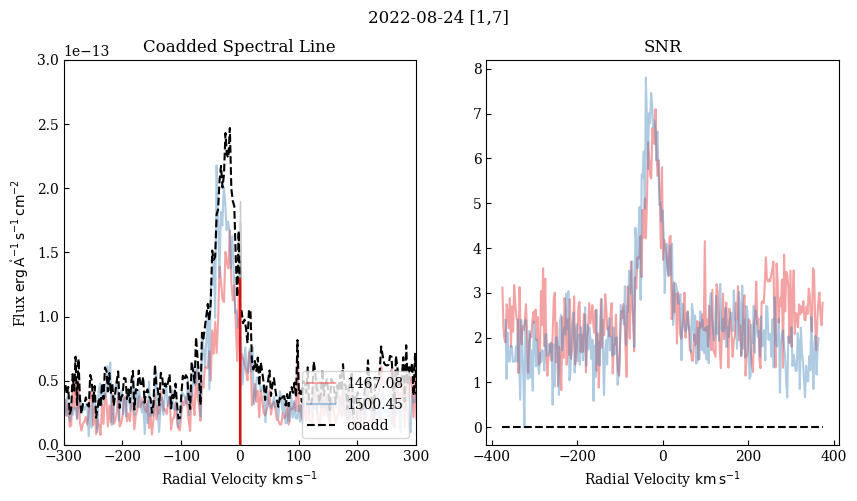

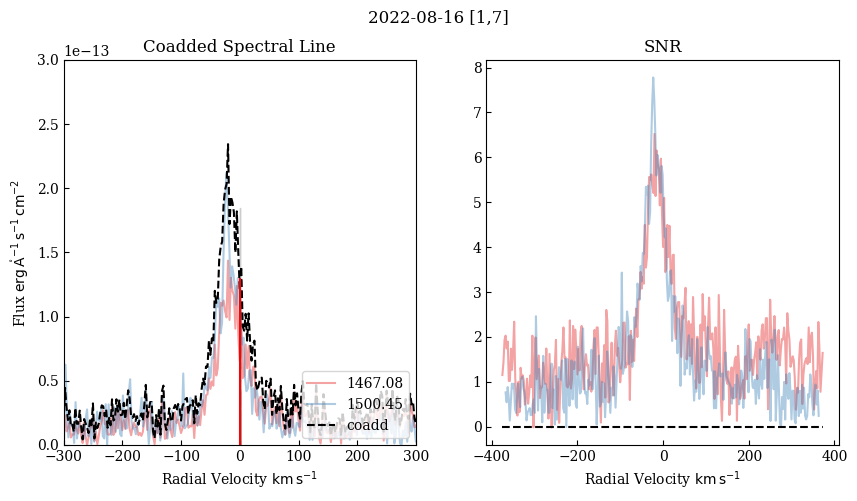

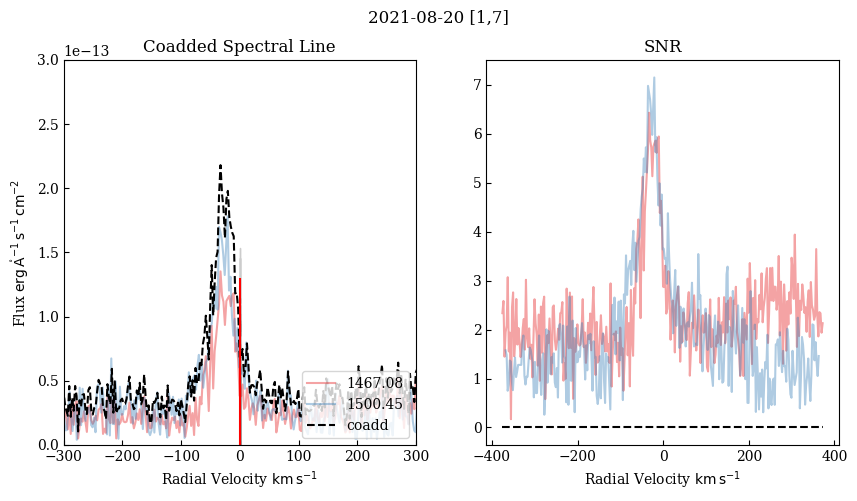

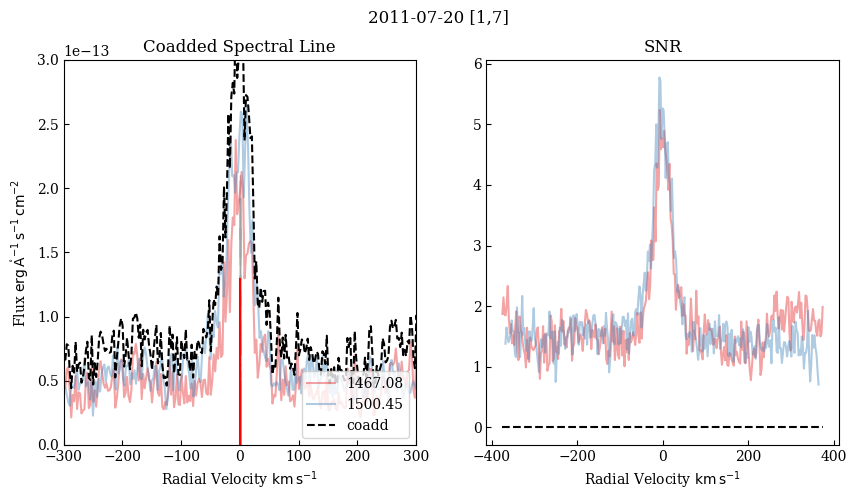

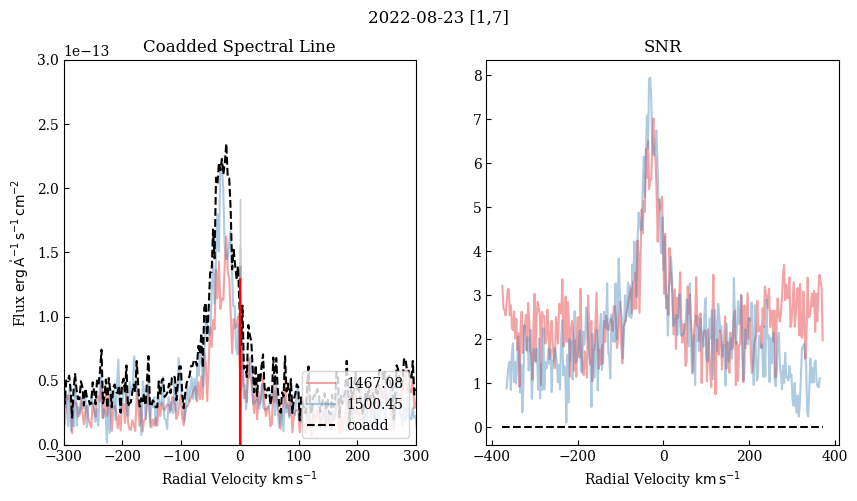

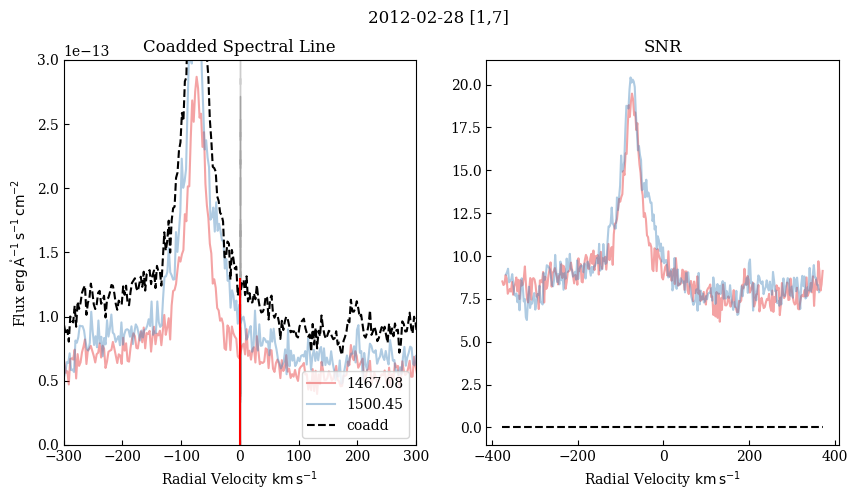

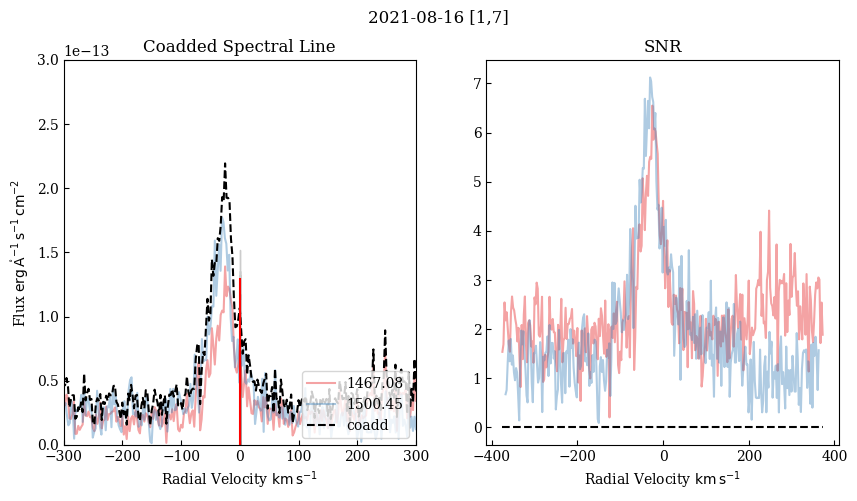

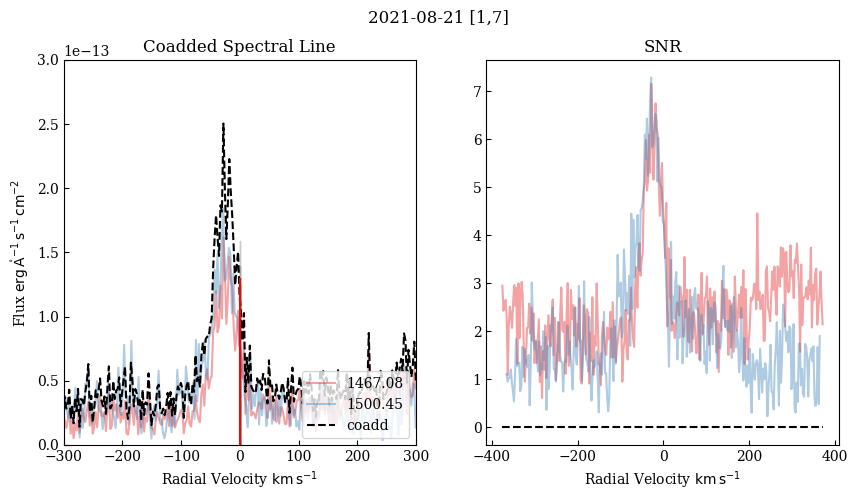

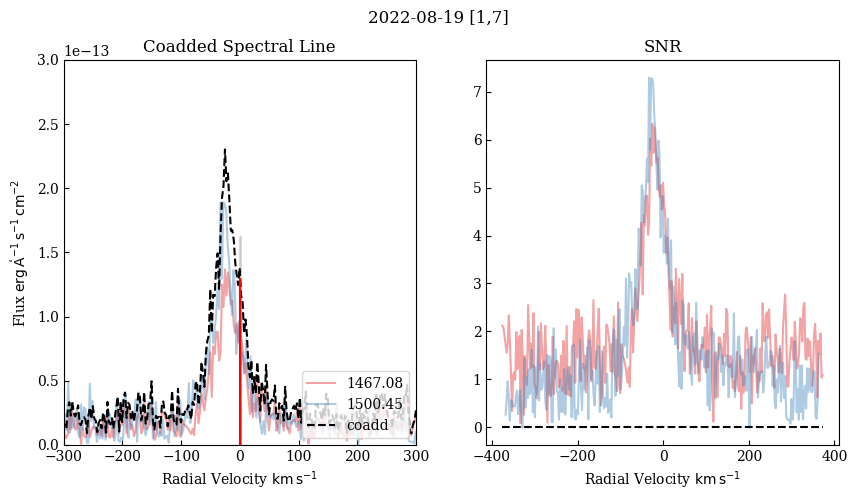

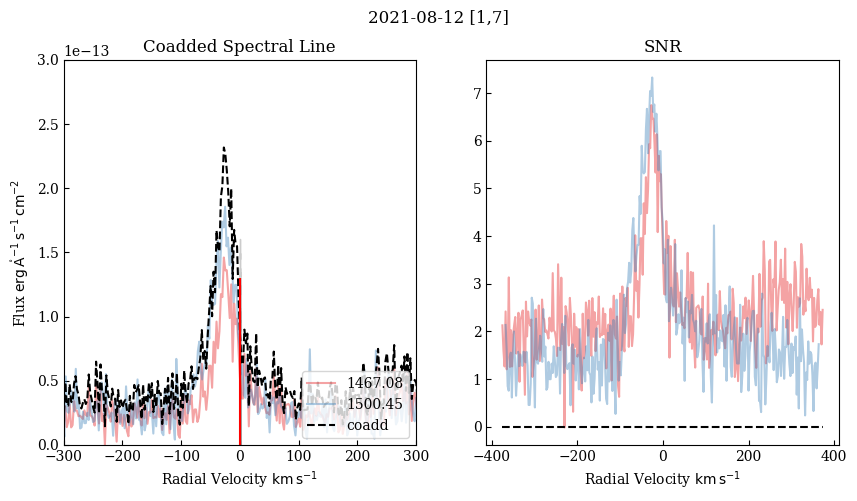

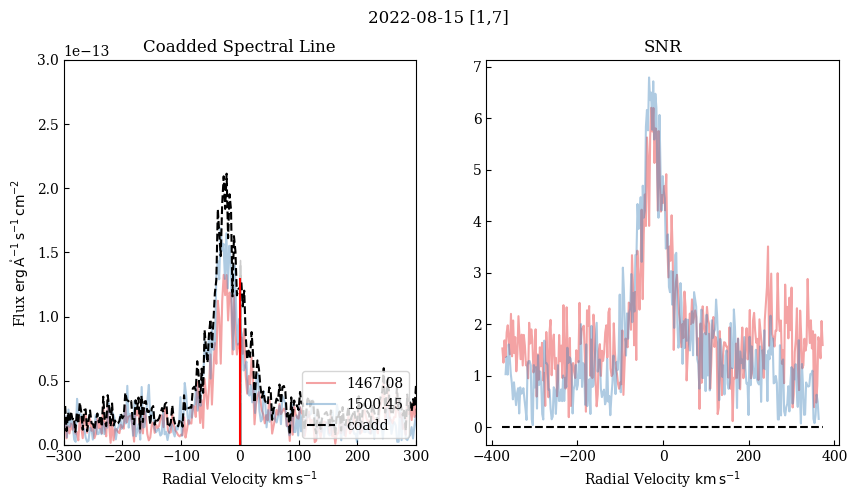

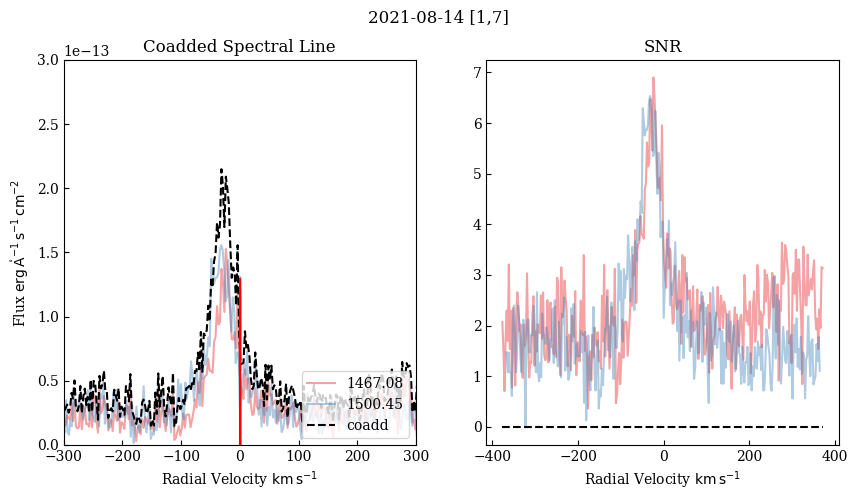

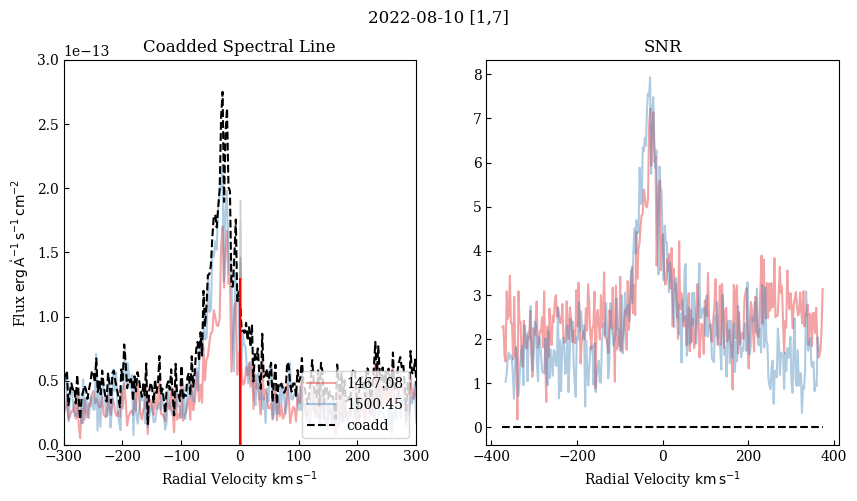

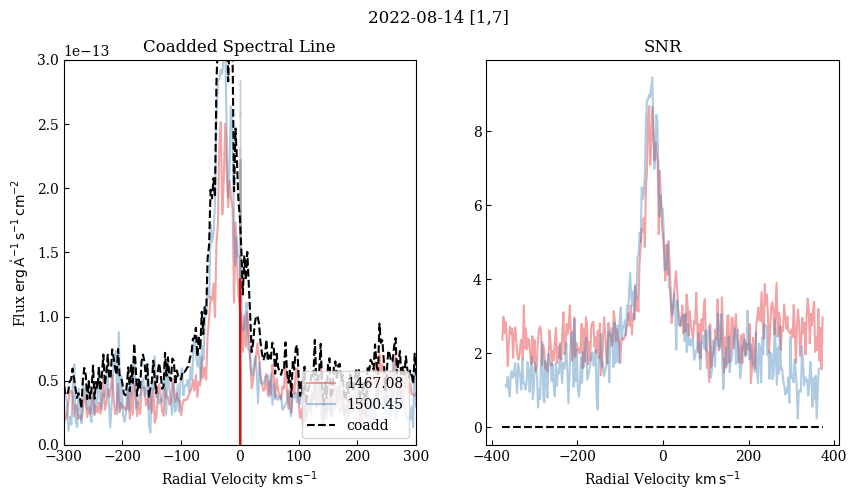

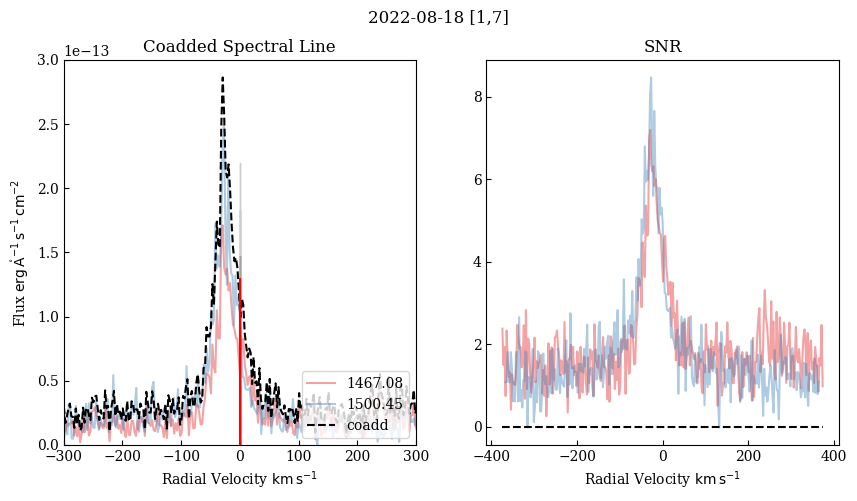

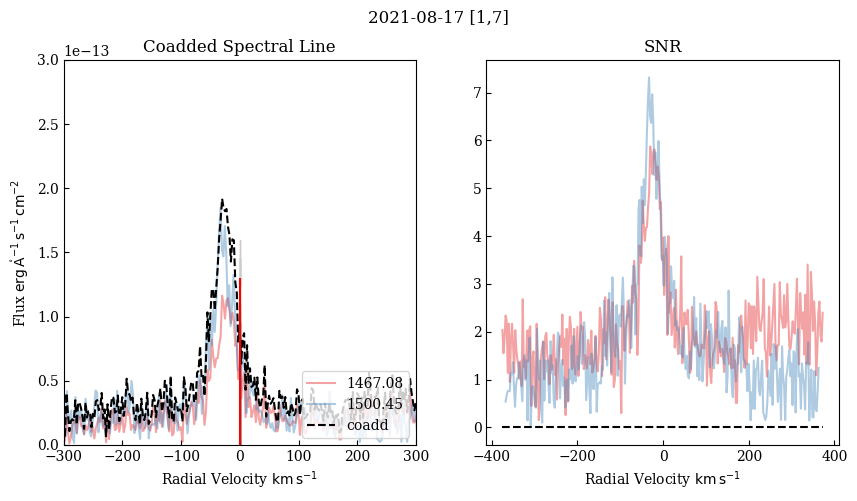

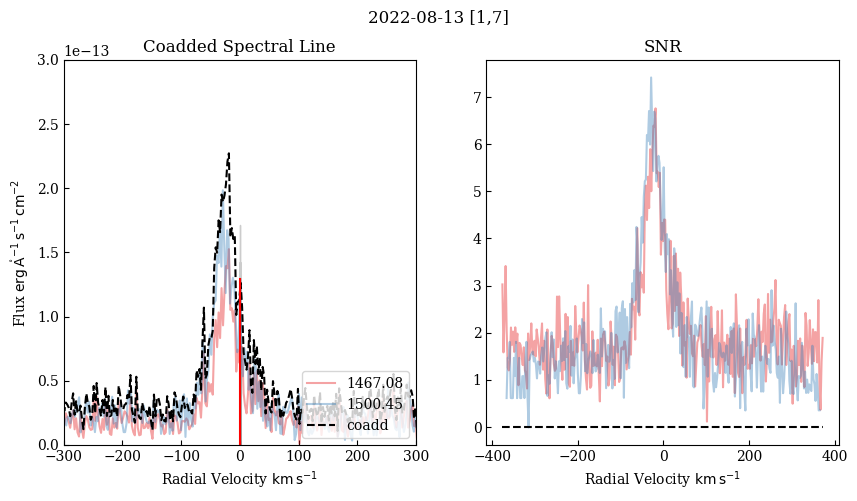

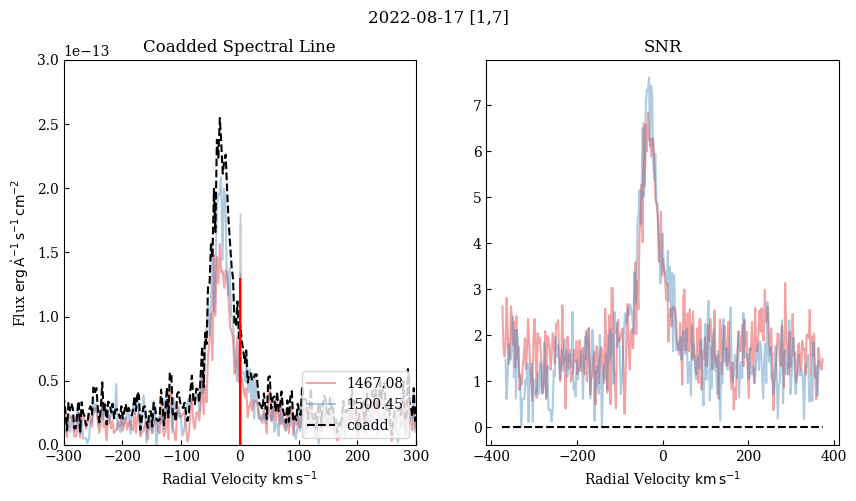

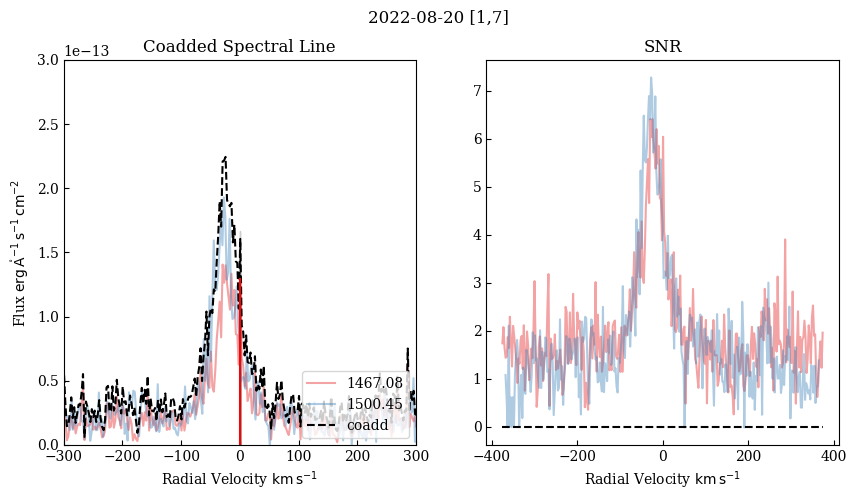

In [30]:
prog_df = all_spectra.coaddvel(line_df_good, columns=['transition', 'obsdate'])

ibm_colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
#for transition_plot in prog_df['transition'].unique():
for transition_plot in ['[1,7]']:
    mask = prog_df['transition']==transition_plot

    for _, row_prog in prog_df[mask].iterrows():
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        fig.suptitle(row_prog['obsdate']+' '+transition_plot)
        coadd_lines = line_df_good[(line_df_good['transition']==transition_plot) & (line_df_good['obsdate']==row_prog['obsdate'])]
        for _, row_line in coadd_lines.iterrows():
            velocity = all_spectra.radial_velocity(row_line['wavelength'], row_line['labline'])
            ax[0].fill_between(row_line['flux'].value+row_line['fluxerr'].value, row_line['flux'].value-row_line['fluxerr'].value, alpha=0.2, color='black')
            ax[0].plot(velocity, row_line['flux'], alpha=0.4, label=row_line['labline'])
            ax[1].plot(velocity, row_line['flux']/row_line['fluxerr'], alpha=0.4, label=row_line['labline'])

            
        ax[0].plot(row_prog['velocity'], row_prog['flux'], c='black', ls='--', label='coadd')
        ax[0].vlines(0, 0,1.3e-13, 'r')

        ax[1].plot(row_prog['velocity'], row_prog['flux'].value/row_prog['fluxerr'].value, c='black', ls='--', label='coadd')
        
        ax[0].set_xlabel('Radial Velocity'+' '+u.format.Latex().to_string(row_prog['velocity'].unit, fraction=False))
        ax[1].set_xlabel('Radial Velocity'+' '+u.format.Latex().to_string(row_prog['velocity'].unit, fraction=False))
        
        ax[0].set_ylabel('Flux'+' '+u.format.Latex().to_string(row_prog['flux'].unit, fraction=False))
        ax[0].text(0.05, 0.95, f'Num lines = {len(coadd_lines)}', transform=plt.gca().transAxes, verticalalignment='top')
        ax[0].set_ylim(0, 3e-13)
        ax[0].set_xlim(-300,300)
        ax[0].legend(loc='lower right')
        ax[0].set_title('Coadded Spectral Line')
        ax[1].set_title('SNR')
        plt.show()